<a href="https://colab.research.google.com/github/rakshitgupta22/predicting-emotions/blob/main/Predicting_Emotions_from_Sound_Events_using_Regression_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Load packages:**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [ ]:
#1 Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#2. Get the file
#make sure you upload all your data files to your Google drive and change share->Advanced->change->anyone with the link can view
downloaded = drive.CreateFile({'id':'1sriupReVhRh5EK2w41QQizYFWj_P0d8z'}) # replace the id with id of file you want to access
downloaded.GetContentFile('EmoSounds.csv') 

downloaded = drive.CreateFile({'id':'1A9yZXyZx5ugZjj7s5Mi-Nb2UWXV2aE6f'}) 
downloaded.GetContentFile('IADSED.csv') 


<a name='load_data'></a>

### 1.1 EmoSounds Dataset Preprocessing

---

Import the csv into a pandas DataFrame.

In [ ]:
# Read EmoSounds.csv into a DataFrame.
emo_sounds_file = 'EmoSounds.csv'

emo_sounds = pd.read_csv(emo_sounds_file)
emo_sounds.head(5)

,dataset,fnames,genre,splits,vocals,arousal,valence,dynamics_rms_mean,dynamics_rms_std,pitch_pitch_mean,...,timbre_lowenergy_mean,timbre_lowenergy_std,timbre_spectralflux_mean,timbre_spectralflux_std,tonal_hcdf_mean,tonal_hcdf_std,tonal_keyclarity_mean,tonal_keyclarity_std,tonal_mode_mean,tonal_mode_std
0,Emo_Soundscapes,r_0human101979_1313063-hq.wav,human,train,Yes,-0.518549,0.302556,0.013444,0.005903,375.990904,...,5.415367,1.558017,10.204444,5.785453,0.244838,0.321193,0.457834,0.171750,-0.043605,0.068892
1,Emo_Soundscapes,r_0human102617_425689-hq.wav,human,train,No,-0.929101,0.564716,0.011291,0.008784,855.112001,...,4.652187,0.537740,9.799859,8.441237,0.629594,0.341241,0.440244,0.132387,-0.023940,0.098591
2,Emo_Soundscapes,r_0human106261_1707984-hq.wav,human,train,Yes,-0.940643,0.345425,0.000291,0.000261,494.090737,...,5.317143,1.175990,0.310226,0.342690,0.451562,0.433910,0.416266,0.162932,-0.032507,0.094219
3,Emo_Soundscapes,r_0human106568_7037-hq.wav,human,train,Yes,0.475680,0.193735,0.052846,0.028216,739.893910,...,4.998831,1.429992,45.529733,29.307053,0.337036,0.215957,0.465368,0.129338,-0.031692,0.096302
4,Emo_Soundscapes,r_0human113598_1015240-hq.wav,human,train,Yes,0.901072,0.429514,0.087529,0.020352,630.302807,...,4.937357,1.028468,67.812560,16.124870,0.195859,0.101366,0.576344,0.150061,-0.086635,0.111011


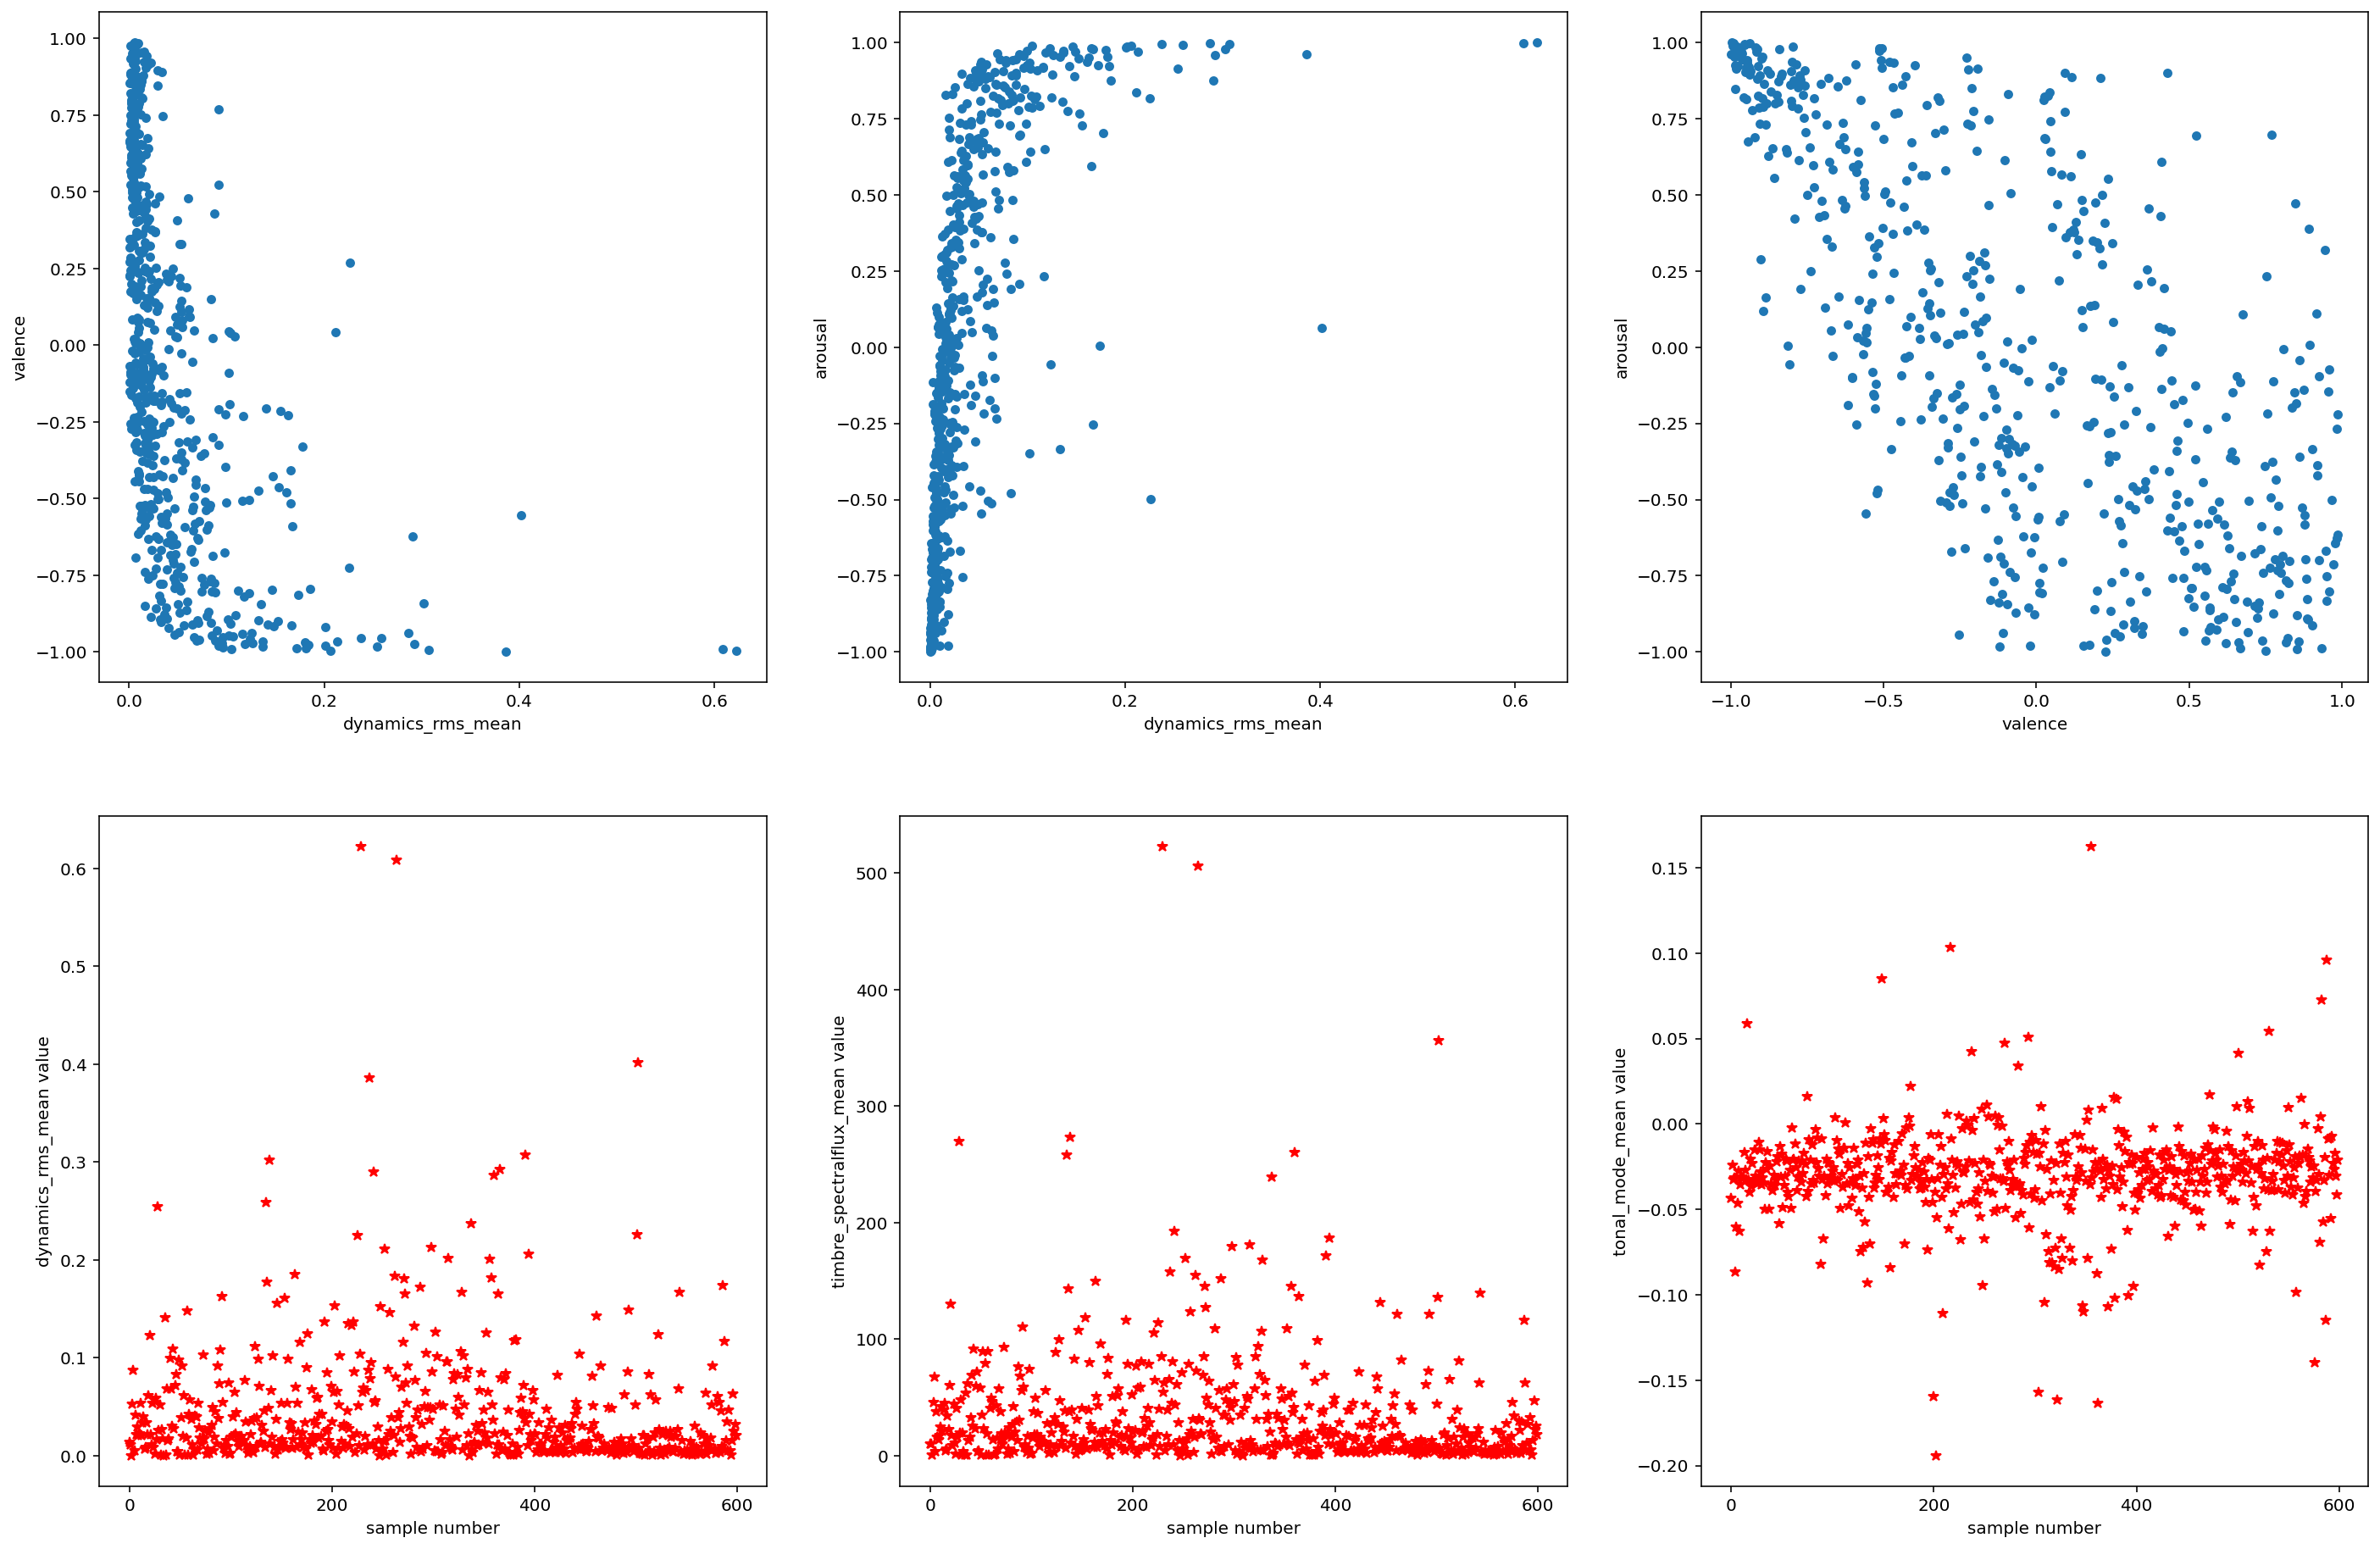

In [ ]:
fig, axes = plt.subplots(2,3, figsize=(24,16))
plt.rcParams['font.size'] = '20'
emo_sounds.plot(ax=axes[0][0], kind='scatter', y='valence', x='dynamics_rms_mean');
emo_sounds.plot(ax=axes[0][1], kind='scatter', y='arousal', x='dynamics_rms_mean');
emo_sounds.plot(ax=axes[0][2], kind='scatter', y='arousal', x='valence');
emo_sounds['dynamics_rms_mean'].plot(ax=axes[1][0], kind='line', style='*r', xlabel='sample number', ylabel='dynamics_rms_mean value');
emo_sounds['timbre_spectralflux_mean'].plot(ax=axes[1][1], kind='line', style='*r',  xlabel='sample number', ylabel='timbre_spectralflux_mean value');
emo_sounds['tonal_mode_mean'].plot(ax=axes[1][2], kind='line', style='*r',   xlabel='sample number', ylabel='tonal_mode_mean value');

In [ ]:
emo_sounds.groupby('splits').count()

,dataset,fnames,genre,vocals,arousal,valence,dynamics_rms_mean,dynamics_rms_std,pitch_pitch_mean,rhythm_attacktime_mean,...,timbre_lowenergy_mean,timbre_lowenergy_std,timbre_spectralflux_mean,timbre_spectralflux_std,tonal_hcdf_mean,tonal_hcdf_std,tonal_keyclarity_mean,tonal_keyclarity_std,tonal_mode_mean,tonal_mode_std
splits,,,,,,,,,,,,,,,,,,,,,
test,300,300,300,300,300,300,300,300,300,300,...,300,300,300,300,300,300,300,300,300,300
train,300,300,300,300,300,300,300,300,300,300,...,300,300,300,300,300,300,300,300,300,300


In [ ]:
emo_sounds['genre'].unique()

array(['human', 'society', 'mechanical', 'indicator', 'nature', 'quiet'],
      dtype=object)

In [ ]:
emo_sounds.columns

Index(['dataset', 'fnames', 'genre', 'splits', 'vocals', 'arousal', 'valence',
       'dynamics_rms_mean', 'dynamics_rms_std', 'pitch_pitch_mean',
       'rhythm_attacktime_mean', 'rhythm_eventdensity_mean',
       'rhythm_fluctuationmax_peakposmean', 'rhythm_pulseclarity_mean',
       'rhythm_tempo_mean', 'rhythm_tempo_std', 'spectral_brightness_mean',
       'spectral_brightness_std', 'spectral_centroid_mean',
       'spectral_centroid_std', 'spectral_flatness_mean',
       'spectral_flatness_std', 'spectral_inharmonicity_mean',
       'spectral_irregularity_mean', 'spectral_kurtosis_mean',
       'spectral_kurtosis_std', 'spectral_mfcc_mean_1',
       'spectral_mfcc_mean_10', 'spectral_mfcc_mean_11',
       'spectral_mfcc_mean_12', 'spectral_mfcc_mean_13',
       'spectral_mfcc_mean_2', 'spectral_mfcc_mean_3', 'spectral_mfcc_mean_4',
       'spectral_mfcc_mean_5', 'spectral_mfcc_mean_6', 'spectral_mfcc_mean_7',
       'spectral_mfcc_mean_8', 'spectral_mfcc_mean_9', 'spectral_mfcc_st

In [ ]:
emo_sounds.shape

(600, 75)

In [ ]:
emo_sounds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 75 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   dataset                            600 non-null    object 
 1   fnames                             600 non-null    object 
 2   genre                              600 non-null    object 
 3   splits                             600 non-null    object 
 4   vocals                             600 non-null    object 
 5   arousal                            600 non-null    float64
 6   valence                            600 non-null    float64
 7   dynamics_rms_mean                  600 non-null    float64
 8   dynamics_rms_std                   600 non-null    float64
 9   pitch_pitch_mean                   600 non-null    float64
 10  rhythm_attacktime_mean             600 non-null    float64
 11  rhythm_eventdensity_mean           600 non-null    float64

In [ ]:
# Get all the columns which have missing values

emo_null_count = emo_sounds.isnull().sum()
emo_null_count[emo_null_count > 0].sort_values(ascending = False)
## There are no missing values in EmoSounds dataset.

Series([], dtype: int64)

In [ ]:
# Normalize all the columns in emo_sounds dataset
# Mean Normalization
num_cols = list(emo_sounds.select_dtypes(include=[np.number]).columns.values)
num_cols.remove('arousal')
num_cols.remove('valence')
normalized_emo_sounds = emo_sounds.copy()
normalized_emo_sounds[num_cols] = (emo_sounds[num_cols]-emo_sounds[num_cols].mean())/emo_sounds[num_cols].std()
normalized_emo_sounds.head()

,dataset,fnames,genre,splits,vocals,arousal,valence,dynamics_rms_mean,dynamics_rms_std,pitch_pitch_mean,...,timbre_lowenergy_mean,timbre_lowenergy_std,timbre_spectralflux_mean,timbre_spectralflux_std,tonal_hcdf_mean,tonal_hcdf_std,tonal_keyclarity_mean,tonal_keyclarity_std,tonal_mode_mean,tonal_mode_std
0,Emo_Soundscapes,r_0human101979_1313063-hq.wav,human,train,Yes,-0.518549,0.302556,-0.471902,-0.476155,-0.850863,...,0.593212,0.548500,-0.465178,-0.448814,-0.248488,0.985985,-0.062700,0.819694,-0.483787,-0.899018
1,Emo_Soundscapes,r_0human102617_425689-hq.wav,human,train,No,-0.929101,0.564716,-0.505316,-0.355873,1.152117,...,-1.175405,-1.067426,-0.473097,-0.343250,3.236817,1.150448,-0.266470,-0.109289,0.198662,0.446407
2,Emo_Soundscapes,r_0human106261_1707984-hq.wav,human,train,Yes,-0.940643,0.345425,-0.676036,-0.711708,-0.357143,...,0.365585,-0.056558,-0.658818,-0.665156,1.624117,1.910655,-0.544242,0.611585,-0.098645,0.248346
3,Emo_Soundscapes,r_0human106568_7037-hq.wav,human,train,Yes,0.475680,0.193735,0.139617,0.455413,0.670444,...,-0.372082,0.345733,0.226172,0.486137,0.586686,0.122686,0.024577,-0.181247,-0.070362,0.342710
4,Emo_Soundscapes,r_0human113598_1015240-hq.wav,human,train,Yes,0.901072,0.429514,0.677898,0.127091,0.212295,...,-0.514543,-0.290205,0.662269,-0.037837,-0.692163,-0.817357,1.310171,0.307825,-1.977090,1.009058


In [ ]:
# Min Max Normalization

normalized_emo_sound_min_max = emo_sounds.copy()

normalized_emo_sound_min_max[num_cols] = (emo_sounds[num_cols]-emo_sounds[num_cols].min())/(emo_sounds[num_cols].max() - emo_sounds[num_cols].min())
normalized_emo_sound_min_max.head()

,dataset,fnames,genre,splits,vocals,arousal,valence,dynamics_rms_mean,dynamics_rms_std,pitch_pitch_mean,...,timbre_lowenergy_mean,timbre_lowenergy_std,timbre_spectralflux_mean,timbre_spectralflux_std,tonal_hcdf_mean,tonal_hcdf_std,tonal_keyclarity_mean,tonal_keyclarity_std,tonal_mode_mean,tonal_mode_std
0,Emo_Soundscapes,r_0human101979_1313063-hq.wav,human,train,Yes,-0.518549,0.302556,0.021317,0.024205,0.134249,...,0.441651,0.393137,0.019267,0.022736,0.300451,0.473395,0.584372,0.563060,0.421966,0.430271
1,Emo_Soundscapes,r_0human102617_425689-hq.wav,human,train,No,-0.929101,0.564716,0.017856,0.036140,0.372146,...,0.159645,0.056379,0.018493,0.033291,0.777505,0.504023,0.560661,0.418816,0.477124,0.626211
2,Emo_Soundscapes,r_0human106261_1707984-hq.wav,human,train,Yes,-0.940643,0.345425,0.000177,0.000833,0.192889,...,0.405356,0.267044,0.000341,0.001105,0.556765,0.645596,0.528339,0.530746,0.453095,0.597366
3,Emo_Soundscapes,r_0human106568_7037-hq.wav,human,train,Yes,0.475680,0.193735,0.084644,0.116640,0.314937,...,0.287735,0.350881,0.086838,0.116217,0.414766,0.312622,0.594527,0.407643,0.455381,0.611109
4,Emo_Soundscapes,r_0human113598_1015240-hq.wav,human,train,Yes,0.901072,0.429514,0.140388,0.084062,0.260522,...,0.265019,0.218352,0.129461,0.063828,0.239722,0.137558,0.744121,0.483581,0.301274,0.708152


In [ ]:
print('The maximum value of arousal is {}'.format(normalized_emo_sound_min_max['arousal'].max()))
print('The minimum value of arousal is {}'.format(normalized_emo_sound_min_max['arousal'].min()))
print('The maximum value of valence is {}'.format(normalized_emo_sound_min_max['valence'].max()))
print('The minimum value of valence is {}'.format(normalized_emo_sound_min_max['valence'].min()))

The maximum value of arousal is 1.0
The minimum value of arousal is -0.998351195
The maximum value of valence is 0.986809563
The minimum value of valence is -0.998351195


<a name='Train_section'></a>

### 1.2 EmoSounds Dataset Training

---

In [ ]:
#Shuffling the dataset
from sklearn.utils import shuffle

emo_sounds_shuffled = shuffle(normalized_emo_sound_min_max)

X_emosounds = emo_sounds_shuffled.iloc[:,7:]
Y_emosounds = emo_sounds_shuffled.iloc[:,5:7]

<a name='linear regression'></a>

#### 1.2.1 Linear Regression


In [ ]:
from sklearn.linear_model import LinearRegression

#Splitting the data into train and test sets after shuffling
#80% 20% split

from sklearn.model_selection import train_test_split
X_emo_train, X_emo_test, Y_emo_train, Y_emo_test,  = train_test_split(X_emosounds, Y_emosounds, test_size=0.2, random_state=0)

In [ ]:
#Fitting Linear Regression to training set

#arousal
reg_Linear_arousal = LinearRegression()
reg_Linear_arousal.fit(X_emo_train, Y_emo_train.iloc[:,0])

#Making predictions for arousal using Linear Regression Model
Y_emo_pred_Linear_arousal = reg_Linear_arousal.predict(X_emo_test) # Test set
Y_emo_pred_Linear_arousal_train = reg_Linear_arousal.predict(X_emo_train) # Train set

#valence
reg_Linear_valence = LinearRegression()
reg_Linear_valence.fit(X_emo_train, Y_emo_train.iloc[:,1])

#Making predictions for valence using Linear Regression Model
Y_emo_pred_Linear_valence = reg_Linear_valence.predict(X_emo_test) # Test set
Y_emo_pred_Linear_valence_train = reg_Linear_valence.predict(X_emo_train) # Train set


In [ ]:
#Calculating the RMSE
from sklearn.metrics import mean_squared_error
import math


#RMSE of "arousal" for training set (Training error)
MSE_Linear_arousal_train = mean_squared_error(np.array(Y_emo_train)[:,0], Y_emo_pred_Linear_arousal_train)
RMSE_Linear_arousal_train = math.sqrt(MSE_Linear_arousal_train)
print("Training error: RMSE for arousal in Emo-soundscape (Linear Regression) :",RMSE_Linear_arousal_train)

#RMSE of "arousal" for testing set (test error)
MSE_Linear_arousal_test = mean_squared_error(np.array(Y_emo_test)[:,0], Y_emo_pred_Linear_arousal)
RMSE_Linear_arousal_test = math.sqrt(MSE_Linear_arousal_test)
print("Test error: RMSE for arousal in Emo-soundscape (Linear Regression) :    ",RMSE_Linear_arousal_test)

#RMSE of "valence" for training set (Training error)
MSE_Linear_valence_train = mean_squared_error(np.array(Y_emo_train)[:,1], Y_emo_pred_Linear_valence_train)
RMSE_Linear_valence_train = math.sqrt(MSE_Linear_valence_train)
print("Training error: RMSE for valence in Emo-soundscape (Linear Regression) :",RMSE_Linear_valence_train)

#RMSE of "arousal" for testing set (test error)
MSE_Linear_valence_test = mean_squared_error(np.array(Y_emo_test)[:,1], Y_emo_pred_Linear_valence)
RMSE_Linear_valence_test = math.sqrt(MSE_Linear_valence_test)
print("Test error: RMSE for valence in Emo-soundscape (Linear Regression) :    ",RMSE_Linear_valence_test)

Training error: RMSE for arousal in Emo-soundscape (Linear Regression) : 0.22675372032988708
Test error: RMSE for arousal in Emo-soundscape (Linear Regression) :     0.34681756457382945
Training error: RMSE for valence in Emo-soundscape (Linear Regression) : 0.3359556136467031
Test error: RMSE for valence in Emo-soundscape (Linear Regression) :     0.4142449880408178


<a name='Random Forest regression'></a>

#### 1.2.2 Random Forest Regression

In [ ]:
#Training the Random Forest Model
from sklearn.ensemble import RandomForestRegressor

#Splitting the dataset into Train, Validate and Test sets for tuning Random Forest into a 60, 20, 20 split (split the train set into 0.75 0.25 to achieve it)
X_emo_train_RF, X_emo_validate_RF, Y_emo_train_RF, Y_emo_validate_RF,  = train_test_split(X_emo_train, Y_emo_train, test_size=0.25, random_state=0)

In [ ]:
#Train model and use validation set to fine tune model

#arousal
reg_RF_arousal = RandomForestRegressor(n_estimators=10, random_state=5)
reg_RF_arousal.fit(X_emo_train_RF, Y_emo_train_RF.iloc[:,0])

#Making predictions for arousal
y_pred_RF_arousal_train = reg_RF_arousal.predict(X_emo_train_RF) #Train set
y_pred_RF_arousal_validate = reg_RF_arousal.predict(X_emo_validate_RF) #Validation set

#RMSE of "arousal" for training set(Training error)
MSE_RF_arousal_train = mean_squared_error(np.array(Y_emo_train_RF)[:,0], y_pred_RF_arousal_train)
RMSE_RF_arousal_train = math.sqrt(MSE_RF_arousal_train)
print("Training error: RMSE for arousal in Emo-soundscape (Random Forest Regression) :", RMSE_RF_arousal_train)

#RMSE of "arousal" for validating set (validate error)
MSE_RF_arousal_validate = mean_squared_error(np.array(Y_emo_validate_RF)[:,0], y_pred_RF_arousal_validate)
RMSE_RF_arousal_validate = math.sqrt(MSE_RF_arousal_validate)
print("Validate error: RMSE for arousal in Emo-soundscape (Random Forest Regression) :", RMSE_RF_arousal_validate)

Training error: RMSE for arousal in Emo-soundscape (Random Forest Regression) : 0.10346647258572376
Validate error: RMSE for arousal in Emo-soundscape (Random Forest Regression) : 0.2365234052917529


In [ ]:
#Making predictions for arousal-- test set
y_pred_RF_arousal_test = reg_RF_arousal.predict(X_emo_test) #Test set

##RMSE of "arousal" for test set (test error)
MSE_RF_arousal_test = mean_squared_error(np.array(Y_emo_test)[:,0], y_pred_RF_arousal_test)
RMSE_RF_arousal_test = math.sqrt(MSE_RF_arousal_test)
print("Test error: RMSE for arousal in Emo-soundscape (Random Forest Regression) :", RMSE_RF_arousal_test)


Test error: RMSE for arousal in Emo-soundscape (Random Forest Regression) : 0.23928244361619866


In [ ]:
#valence
reg_RF_valence = RandomForestRegressor(n_estimators=60, random_state=5)
reg_RF_valence.fit(X_emo_train_RF, Y_emo_train_RF.iloc[:,1])

#Making predictions for valence 
y_pred_RF_valence_train = reg_RF_valence.predict(X_emo_train_RF) #Train set
y_pred_RF_valence_validate = reg_RF_valence.predict(X_emo_validate_RF) #Validation set

#RMSE of "valence" for training set(Training error)
MSE_RF_valence_train = mean_squared_error(np.array(Y_emo_train_RF)[:,1], y_pred_RF_valence_train)
RMSE_RF_valence_train = math.sqrt(MSE_RF_valence_train)
print("Training error: RMSE for valence in Emo-soundscape (Random Forest Regression) :", RMSE_RF_valence_train)

#RMSE of "valence" for validating set (validate error)
MSE_RF_valence_validate = mean_squared_error(np.array(Y_emo_validate_RF)[:,1], y_pred_RF_valence_validate)
RMSE_RF_valence_validate = math.sqrt(MSE_RF_valence_validate)
print("Validate error: RMSE for valence in Emo-soundscape (Random Forest Regression) :", RMSE_RF_valence_validate)

Training error: RMSE for valence in Emo-soundscape (Random Forest Regression) : 0.14117472828490343
Validate error: RMSE for valence in Emo-soundscape (Random Forest Regression) : 0.42211729074115656


In [ ]:
#Making predictions for valence-- test set
y_pred_RF_valence_test = reg_RF_valence.predict(X_emo_test) #Test set

##RMSE of "valence" for test set (test error)
MSE_RF_valence_test = mean_squared_error(np.array(Y_emo_test)[:,1], y_pred_RF_valence_test)
RMSE_RF_valence_test = math.sqrt(MSE_RF_valence_test)
print("Test error: RMSE for valence in Emo-soundscape (Random Forest Regression) :", RMSE_RF_valence_test)

# Note: the gap between training error and test error is large, we might have overfitting problem.

Test error: RMSE for valence in Emo-soundscape (Random Forest Regression) : 0.34350961471598174


<a name='Polynomial Model Training'></a>

#### 1.2.3 Polynomial Regression


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
polyreg = PolynomialFeatures(degree=3)

#Generating the polynomial feature
X_poly = polyreg.fit_transform(X_emo_train)

#Training the polynomial model
poly_regressor_arousal = LinearRegression()
poly_regressor_arousal.fit(X_poly, Y_emo_train.iloc[:,0])

poly_regressor_valence = LinearRegression()
poly_regressor_valence.fit(X_poly, Y_emo_train.iloc[:,1])

#Generating polynomial features for test set
X_emo_test_poly = polyreg.transform(X_emo_test)


In [ ]:
#Making Predictions
y_pred_arousal_poly = poly_regressor_arousal.predict(X_emo_test_poly)
y_pred_valence_poly = poly_regressor_valence.predict(X_emo_test_poly)
y_pred_arousal_poly_train = poly_regressor_arousal.predict(X_poly)
y_pred_valence_poly_train = poly_regressor_valence.predict(X_poly)

In [ ]:
#RMSE of "arousal" for training set (Training error)
MSE_Poly_arousal_train = mean_squared_error(np.array(Y_emo_train)[:,0], y_pred_arousal_poly_train)
RMSE_Poly_arousal_train = math.sqrt(MSE_Poly_arousal_train)
print("Training error: RMSE for arousal in Emo-soundscape (Linear Regression (degree 3)) :",RMSE_Poly_arousal_train)

#RMSE of "arousal" for testing set (test error)
MSE_Poly_arousal_test = mean_squared_error(np.array(Y_emo_test)[:,0], y_pred_arousal_poly)
RMSE_Poly_arousal_test = math.sqrt(MSE_Poly_arousal_test)
print("Test error: RMSE for arousal in Emo-soundscape (Linear Regression (degree 3)) :    ",RMSE_Poly_arousal_test)

#RMSE of "valence" for training set (Training error)
MSE_Poly_valence_train = mean_squared_error(np.array(Y_emo_train)[:,1], y_pred_valence_poly_train)
RMSE_Poly_valence_train = math.sqrt(MSE_Poly_valence_train)
print("Training error: RMSE for valence in Emo-soundscape (Linear Regression (degree 3)) :",RMSE_Poly_valence_train)

#RMSE of "valence" for testing set (test error)
MSE_Poly_valence_test = mean_squared_error(np.array(Y_emo_test)[:,1], y_pred_valence_poly)
RMSE_Poly_valence_test = math.sqrt(MSE_Poly_valence_test)
print("Test error: RMSE for valence in Emo-soundscape (Linear Regression (degree 3)) :    ",RMSE_Poly_valence_test)

#The difference in training and testing error is too huge, hence this is the case of overfitting

Training error: RMSE for arousal in Emo-soundscape (Linear Regression (degree 3)) : 4.174149443838227e-15
Test error: RMSE for arousal in Emo-soundscape (Linear Regression (degree 3)) :     0.4490524150978236
Training error: RMSE for valence in Emo-soundscape (Linear Regression (degree 3)) : 4.7840777636844536e-15
Test error: RMSE for valence in Emo-soundscape (Linear Regression (degree 3)) :     0.7646201193445682


In [ ]:
#Reducing the polynomial function to degree 2
polyreg2 = PolynomialFeatures(degree=2)

#Generating the polynomial feature
X_poly2 = polyreg2.fit_transform(X_emo_train)

#Training the polynomial model
poly_regressor_arousal2 = LinearRegression()
poly_regressor_arousal2.fit(X_poly2, Y_emo_train.iloc[:,0])

poly_regressor_valence2 = LinearRegression()
poly_regressor_valence2.fit(X_poly2, Y_emo_train.iloc[:,1])

#Generating polynomial features for test set
X_emo_test_poly2 = polyreg2.transform(X_emo_test)

In [ ]:
#Making Predictions
y_pred_arousal_poly2 = poly_regressor_arousal2.predict(X_emo_test_poly2)
y_pred_valence_poly2 = poly_regressor_valence2.predict(X_emo_test_poly2)
y_pred_arousal_poly_train2 = poly_regressor_arousal2.predict(X_poly2)
y_pred_valence_poly_train2 = poly_regressor_valence2.predict(X_poly2)

In [ ]:
#RMSE of "arousal" for training set (Training error)
MSE_Poly_arousal_train2 = mean_squared_error(np.array(Y_emo_train)[:,0], y_pred_arousal_poly_train2)
RMSE_Poly_arousal_train2 = math.sqrt(MSE_Poly_arousal_train2)
print("Training error: RMSE for arousal in Emo-soundscape (Linear Regression (degree 2)) :",RMSE_Poly_arousal_train2)

#RMSE of "arousal" for testing set (test error)
MSE_Poly_arousal_test2 = mean_squared_error(np.array(Y_emo_test)[:,0], y_pred_arousal_poly2)
RMSE_Poly_arousal_test2 = math.sqrt(MSE_Poly_arousal_test2)
print("Test error: RMSE for arousal in Emo-soundscape (Linear Regression (degree 2)) :    ",RMSE_Poly_arousal_test2)

#RMSE of "valence" for training set (Training error)
MSE_Poly_valence_train2 = mean_squared_error(np.array(Y_emo_train)[:,1], y_pred_valence_poly_train2)
RMSE_Poly_valence_train2 = math.sqrt(MSE_Poly_valence_train2)
print("Training error: RMSE for valence in Emo-soundscape (Linear Regression (degree 2)) :",RMSE_Poly_valence_train2)

#RMSE of "valence" for testing set (test error)
MSE_Poly_valence_test2 = mean_squared_error(np.array(Y_emo_test)[:,1], y_pred_valence_poly2)
RMSE_Poly_valence_test2 = math.sqrt(MSE_Poly_valence_test2)
print("Test error: RMSE for valence in Emo-soundscape (Linear Regression (degree 2)) :    ",RMSE_Poly_valence_test2)

Training error: RMSE for arousal in Emo-soundscape (Linear Regression (degree 2)) : 3.0841560320660393e-15
Test error: RMSE for arousal in Emo-soundscape (Linear Regression (degree 2)) :     0.4819764418154541
Training error: RMSE for valence in Emo-soundscape (Linear Regression (degree 2)) : 5.248230931751583e-15
Test error: RMSE for valence in Emo-soundscape (Linear Regression (degree 2)) :     0.8145649899992685


In [ ]:
#Regularization
from sklearn.linear_model import LassoCV

#Train model
#arousal
reg_poly2_model_arousal = LassoCV(alphas=np.arange(0, 1, 0.01), cv=5, n_jobs=-1)
reg_poly2_model_arousal.fit(X_poly2, Y_emo_train.iloc[:,0])

#valence
reg_poly2_model_valence = LassoCV(alphas=np.arange(0, 1, 0.01), cv=5, n_jobs=-1)
reg_poly2_model_valence.fit(X_poly2, Y_emo_train.iloc[:,1])

print("The optimum value of alpha for arousal prediction :",reg_poly2_model_arousal.alpha_)
print("The optimum value of alpha for valence prediction :",reg_poly2_model_valence.alpha_)

The optimum value of alpha for arousal prediction : 0.01
The optimum value of alpha for valence prediction : 0.01


In [ ]:
#Making predictions for regularized polynomial function
#arousal
y_pred_regPoly2_test_arousal = reg_poly2_model_arousal.predict(X_emo_test_poly2)
y_pred_regPoly2_train_arousal = reg_poly2_model_arousal.predict(X_poly2)

#valence
y_pred_regPoly2_test_valence = reg_poly2_model_valence.predict(X_emo_test_poly2)
y_pred_regPoly2_train_valence = reg_poly2_model_valence.predict(X_poly2)

In [ ]:
#RMSE of "arousal" for training set (Training error)
RMSE_reg_Poly_arousal_train2 = math.sqrt(mean_squared_error(np.array(Y_emo_train)[:,0], y_pred_regPoly2_train_arousal))
print("Training error: RMSE for arousal in Emo-soundscape (Linear Regression (degree 2)) :",RMSE_reg_Poly_arousal_train2)

#RMSE of "arousal" for testing set (test error)
RMSE_reg_Poly_arousal_test2 = math.sqrt(mean_squared_error(np.array(Y_emo_test)[:,0], y_pred_regPoly2_test_arousal))
print("Test error: RMSE for arousal in Emo-soundscape (Linear Regression (degree 2))     :",RMSE_reg_Poly_arousal_test2)

#RMSE of "valence" for training set (Training error)
RMSE_reg_Poly_valence_train2 = math.sqrt(mean_squared_error(np.array(Y_emo_train)[:,1], y_pred_regPoly2_train_valence))
print("Training error: RMSE for valence in Emo-soundscape (Linear Regression (degree 2)) :",RMSE_reg_Poly_valence_train2)

#RMSE of "valence" for testing set (test error)
RMSE_reg_Poly_valence_test2 = math.sqrt(mean_squared_error(np.array(Y_emo_test)[:,1], y_pred_regPoly2_test_valence))
print("Test error: RMSE for arousal in Emo-soundscape (Linear Regression (degree 2))     :",RMSE_reg_Poly_valence_test2)

Training error: RMSE for arousal in Emo-soundscape (Linear Regression (degree 2)) : 0.3506557530569891
Test error: RMSE for arousal in Emo-soundscape (Linear Regression (degree 2))     : 0.36794284971377184
Training error: RMSE for valence in Emo-soundscape (Linear Regression (degree 2)) : 0.42390936013474245
Test error: RMSE for arousal in Emo-soundscape (Linear Regression (degree 2))     : 0.4035845001158183


<a name='Cross validation_section'></a>

### 1.3 EmoSounds Dataset 5-fold cross validation

---

In [ ]:
from sklearn.model_selection import KFold

def cross_validate(num_splits, X, Y, model):

  kf = KFold(n_splits=num_splits, shuffle= True, random_state=0)
  rmse_list = []

  for train_idx, test_idx in kf.split(X, Y):
    x_train = X.iloc[train_idx]
    y_train = Y.iloc[train_idx]

    x_test = X.iloc[test_idx]
    y_test = Y.iloc[test_idx]

    model.fit(x_train, y_train) #Training the model
    
    #Making Predictions
    y_pred = model.predict(x_test)

    #RMSE
    rmse_list.append(math.sqrt(mean_squared_error(y_test, y_pred)))

  return rmse_list


In [ ]:
X_emosounds = normalized_emo_sound_min_max.iloc[:,7:]
y_emosounds = normalized_emo_sound_min_max.iloc[:,5:7]

#Linear Regression
lr_cv_arousal = LinearRegression()
rmse_cv_linear_arousal = cross_validate(5, X_emosounds, y_emosounds.iloc[:,0], lr_cv_arousal)
print("RMSE for each fold of Linear Regression Model (arousal) ",rmse_cv_linear_arousal)
print("Average RMSE (arousal) ",np.mean(rmse_cv_linear_arousal))

lr_cv_valence = LinearRegression()
rmse_cv_linear_valence = cross_validate(5, X_emosounds, y_emosounds.iloc[:,1], lr_cv_valence)
print("RMSE for each fold of Linear Regression Model (valence) ",rmse_cv_linear_valence)
print("Average RMSE (valence) ",np.mean(rmse_cv_linear_valence))

RMSE for each fold of Linear Regression Model (arousal)  [0.269049786321642, 0.296523311162918, 0.3145183744324029, 0.3488604899223996, 0.28340972792159447]
Average RMSE (arousal)  0.3024723379521914
RMSE for each fold of Linear Regression Model (valence)  [0.3687269937144975, 0.46914885240039106, 0.4261875690545062, 0.47311000443588447, 0.3848607535276038]
Average RMSE (valence)  0.4244068346265766


In [ ]:
#Random Forest arousal
rf_cv_arousal = RandomForestRegressor(n_estimators=50, random_state=2)
rmse_cv_rf_arousal = cross_validate(5, X_emosounds, y_emosounds.iloc[:,0], rf_cv_arousal)
print("RMSE for each fold of Random Forest Regression Model (arousal) ",rmse_cv_rf_arousal)
print("Average RMSE (arousal) ",np.mean(rmse_cv_rf_arousal))

RMSE for each fold of Random Forest Regression Model (arousal)  [0.2620290055465196, 0.24315370310532905, 0.20190503230082252, 0.2579050003916981, 0.21258273051338406]
Average RMSE (arousal)  0.23551509437155066


In [ ]:
#Random Forest valence
rf_cv_valence = RandomForestRegressor(n_estimators=60, random_state=5)
rmse_cv_rf_valence = cross_validate(5, X_emosounds, y_emosounds.iloc[:,1], rf_cv_valence)
print("RMSE for each fold of Random Forest Regression Model (valence) ",rmse_cv_rf_valence)
print("Average RMSE (valence) ",np.mean(rmse_cv_rf_valence))

RMSE for each fold of Random Forest Regression Model (valence)  [0.34389868526383927, 0.4103751864917622, 0.35148776477108123, 0.36860594167393806, 0.36954210873787197]
Average RMSE (valence)  0.36878193738769854


<a name='Feature selection'></a>

### 1.4 Feature selection


<a name='Filter method'></a>

#### 1.4.1 Filter method


Preprocessing part of the filter method.

In [ ]:
# shuffle the dataset and split into training/test sets ---- 80% 20%
emo_sounds_shuffled = shuffle(normalized_emo_sound_min_max)

X_emosounds = emo_sounds_shuffled.iloc[:,7:]
y_emosounds = emo_sounds_shuffled.iloc[:,5:7]

X_emo_train, X_emo_test, y_emo_train, y_emo_test = train_test_split(X_emosounds, y_emosounds, test_size=0.2, random_state=0)

In [ ]:
# original X_emo_train shape
X_emo_train.shape

(480, 68)

In [ ]:
# Removing Constant features using VarianceThreshold

from sklearn.feature_selection import VarianceThreshold

constant_filter = VarianceThreshold(threshold=0)

#Fit and transforming on train data
data_constant = constant_filter.fit_transform(X_emo_train)

#Extracting all constant columns using get support function of our filter
constant_columns = [column for column in X_emo_train.columns
                   if column not in X_emo_train.columns[constant_filter.get_support()]]

#No. of constant columns
print(len(constant_columns))
print("No constant features were found.")


0
No constant features were found.


In [ ]:
# Removing Quasi-Constant Features

qcons_filter = VarianceThreshold(threshold=0.01)

#Fitand transforming on train data
data_qcons = qcons_filter.fit_transform(X_emo_train)

#Extracting all Quasi constant columns using get support function of our filter
qcons_columns = [column for column in X_emo_train.columns
                    if column not in X_emo_train.columns[qcons_filter.get_support()]]

#No. of Quasi constant columns
print(len(qcons_columns)) 
print(f'{len(qcons_columns)} quasi-constant features were found.')

#Removing identified quasi-constant columns
X_emo_train1 = X_emo_train.drop(qcons_columns,axis=1)
X_emo_test1 = X_emo_test.drop(qcons_columns,axis=1)
print(X_emo_train1.shape)
print(X_emo_test1.shape)

17
17 quasi-constant features were found.
(480, 51)
(120, 51)


In [ ]:
# Correlation Pearson Correlation: for numerical input and numerical output
#import seaborn as sns
#sns.set_style('darkgrid')

#show correlation among variables using Pearson Correlation
#cor = X_emo_train1.corr()
#plt.figure(figsize=(12,10))
#sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
#plt.show()

In [ ]:
# Function to find highly correlated features. it will put the first feature that is correlated with anything other feature into a set
# def correlation(dataset, threshold):
#     col_corr = set()  # Set of all the names of correlated columns
#     corr_matrix = dataset.corr()
#     for i in range(len(corr_matrix.columns)):
#         for j in range(i):
#             if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
#                 colname = corr_matrix.columns[i]  # getting the name of column
#                 col_corr.add(colname)
#     return col_corr

In [ ]:
# Columns to drop
# corr_features_to_drop = correlation(X_emo_train1, 0.9)
# len(set(corr_features_to_drop))

# Drop highly correlated columns
# X_emo_train2 = X_emo_train1.drop(corr_features_to_drop, axis=1)
# X_emo_test2 = X_emo_test1.drop(corr_features_to_drop, axis=1)
# print(X_emo_train2.shape)
# print(X_emo_test2.shape)
# print(X_emosounds.shape)

<a name='Training with selected features'></a>

##### 1.4.1.1  Linear Regression

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# feature selection
def select_features(X_train, y_train, X_test, num):
	# configure to select "num" features
	fs = SelectKBest(score_func=f_regression, k=num)
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

In [ ]:
## Arousal

# Select K best features, change "num" to get the best results.
X_emo_arousal_train_filter, X_emo_arousal_test_filter, fs_arousal = select_features(X_emo_train1, y_emo_train.iloc[:, 0], X_emo_test1, 18)

In [ ]:
# Fitting Linear Regression to training set
lr_arousal_filter = LinearRegression()
lr_arousal_filter.fit(X_emo_arousal_train_filter, y_emo_train.iloc[:, 0])

# Making predictions 
y_emo_pred_lr_arousal_train_filter = lr_arousal_filter.predict(X_emo_arousal_train_filter) # Train set
y_emo_pred_lr_arousal_test_filter = lr_arousal_filter.predict(X_emo_arousal_test_filter) # Test set

# Calculating the RMSE
# Training set (Training error)
MSE_lr_arousal_train_filter = mean_squared_error(np.array(y_emo_train)[:,0], y_emo_pred_lr_arousal_train_filter)
RMSE_lr_arousal_train_filter = math.sqrt(MSE_lr_arousal_train_filter)
print("Training error/RMSE for arousal in Emo-soundscape (Linear Regression) with filtered features:",RMSE_lr_arousal_train_filter)

# Testing set (test error)
MSE_lr_arousal_test_filter = mean_squared_error(np.array(y_emo_test)[:,0], y_emo_pred_lr_arousal_test_filter)
RMSE_lr_arousal_test_filter = math.sqrt(MSE_lr_arousal_test_filter)
print("Test error/RMSE for arousal in Emo-soundscape (Linear Regression) with filtered features:    ",RMSE_lr_arousal_test_filter)

Training error/RMSE for arousal in Emo-soundscape (Linear Regression) with filtered features: 0.294549648326865
Test error/RMSE for arousal in Emo-soundscape (Linear Regression) with filtered features:     0.25918970512522366


In [ ]:
## Valence

# Select K best features, change "num" to get the best results.
X_emo_valence_train_filter, X_emo_valence_test_filter, fs_valence = select_features(X_emo_train1, y_emo_train.iloc[:, 1], X_emo_test1, 15)

In [ ]:
# Fitting Linear Regression to training set
lr_valence_filter = LinearRegression()
lr_valence_filter.fit(X_emo_valence_train_filter, y_emo_train.iloc[:,1])

# Making predictions for valence using Linear Regression Model
y_emo_pred_lr_valence_train_filter = lr_valence_filter.predict(X_emo_valence_train_filter) # Train set
y_emo_pred_lr_valence_test_filter = lr_valence_filter.predict(X_emo_valence_test_filter) # Test set

# Calculating the RMSE
# Training set (Training error)
MSE_lr_valence_train_filter = mean_squared_error(np.array(y_emo_train)[:,1], y_emo_pred_lr_valence_train_filter)
RMSE_lr_valence_train_filter = math.sqrt(MSE_lr_valence_train_filter)
print("Training error: RMSE for valence in Emo-soundscape (Linear Regression) with selected features:",RMSE_lr_valence_train_filter)

# Testing set (test error)
MSE_lr_valence_test_filter = mean_squared_error(np.array(y_emo_test)[:,1], y_emo_pred_lr_valence_test_filter)
RMSE_lr_valence_test_filter = math.sqrt(MSE_lr_valence_test_filter)
print("Test error: RMSE for valence in Emo-soundscape (Linear Regression) with selected features:    ",RMSE_lr_valence_test_filter)

Training error: RMSE for valence in Emo-soundscape (Linear Regression) with selected features: 0.38639487855950205
Test error: RMSE for valence in Emo-soundscape (Linear Regression) with selected features:     0.375616272934145


<a name='Training with selected features'></a>

##### 1.4.1.2  Random Forest Regression


In [ ]:
## Arousal

# Select K best features, change "num" to get the best results.
X_emo_arousal_train_filter, X_emo_arousal_test_filter, fs_arousal = select_features(X_emo_train1, y_emo_train.iloc[:, 0], X_emo_test1, 15)

In [ ]:
#Use GridSearch to fine tune model

from sklearn.model_selection import GridSearchCV

rf_arousal_filter = RandomForestRegressor()
tune_paragm = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 50, 100],
    'min_samples_split': [2, 3, 5, 7],
    'min_samples_leaf': [1, 3, 5]
}
rf_gdcv_arousal_filter = GridSearchCV(rf_arousal_filter, tune_paragm, n_jobs=-1, cv=5)
rf_gdcv_arousal_filter.fit(X_emo_arousal_train_filter, y_emo_train.iloc[:, 0])


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [10, 50, 100],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 3, 5, 7],
                         'n_estimators': [50, 100, 150]})

In [ ]:
# Get the best parameters
rf_gdcv_arousal_filter.best_params_

# Save the seed
# num=14: max_depth': 100, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100
# num=15: 'max_depth': 10,  'min_samples_leaf': 1,  'min_samples_split': 3,   'n_estimators': 50
# num=16: 'max_depth': 100, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100

{'max_depth': 50,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 150}

In [ ]:
# Create a regressor using best parameters
rf_arousal_filter = RandomForestRegressor(n_estimators=100, max_depth=100, min_samples_split=3, min_samples_leaf=1)
rf_arousal_filter.fit(X_emo_arousal_train_filter, y_emo_train.iloc[:, 0])

# Making predictions 
y_pred_rf_arousal_train_filter = rf_arousal_filter.predict(X_emo_arousal_train_filter) #Train set
y_pred_rf_arousal_test_filter = rf_arousal_filter.predict(X_emo_arousal_test_filter) #Test

# Calculating the RMSE
# Training set(Training error)
MSE_rf_arousal_train_filter = mean_squared_error(np.array(y_emo_train)[:,0], y_pred_rf_arousal_train_filter)
RMSE_rf_arousal_train_filter = math.sqrt(MSE_rf_arousal_train_filter)
print("Training error: RMSE for arousal in Emo-soundscape (Random Forest Regression) with filtered features:", RMSE_rf_arousal_train_filter)

# Test set (test error)
MSE_rf_arousal_test_filter = mean_squared_error(np.array(y_emo_test)[:,0], y_pred_rf_arousal_test_filter)
RMSE_rf_arousal_test_filter = math.sqrt(MSE_rf_arousal_test_filter)
print("Test error: RMSE for arousal in Emo-soundscape (Random Forest Regression) with filtered features:", RMSE_rf_arousal_test_filter)

Training error: RMSE for arousal in Emo-soundscape (Random Forest Regression) with filtered features: 0.1008042049103538
Test error: RMSE for arousal in Emo-soundscape (Random Forest Regression) with filtered features: 0.23987731435842424


In [ ]:
## Valence

# Select K best features, change "num" to get the best results.
X_emo_valence_train_filter, X_emo_valence_test_filter, fs_valence = select_features(X_emo_train1, y_emo_train.iloc[:, 1], X_emo_test1, 13)

In [ ]:
#Use GridSearch to fine tune model

rf_valence_filter = RandomForestRegressor()
tune_paragm = {
    'n_estimators': [50, 100, 150],
    'max_depth': [50, 100, 150],
    'min_samples_split': [2, 3, 5, 7],
    'min_samples_leaf': [1, 3, 5]
}
rf_gdcv_valence_filter = GridSearchCV(rf_valence_filter, tune_paragm, n_jobs=-1, cv=5)
rf_gdcv_valence_filter.fit(X_emo_valence_train_filter, y_emo_train.iloc[:, 1])

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [50, 100, 150],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 3, 5, 7],
                         'n_estimators': [50, 100, 150]})

In [ ]:
# Get the best parameters
rf_gdcv_arousal_filter.best_params_

# Save the seed 
# num=12: max_depth': 100, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100
# num=13: max_depth': 100, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100
# num=14: max_depth': 100, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100

{'max_depth': 50,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 150}

In [ ]:
# Create a regressor using best parameters
rf_valence_filter = RandomForestRegressor(n_estimators=100, max_depth=100, min_samples_split=2, min_samples_leaf=1)
rf_valence_filter.fit(X_emo_valence_train_filter, y_emo_train.iloc[:, 1])

#Making predictions for valence
y_pred_rf_valence_train_filter = rf_valence_filter.predict(X_emo_valence_train_filter) #Train set
y_pred_rf_valence_test_filter = rf_valence_filter.predict(X_emo_valence_test_filter) #Test set

# Calculating the RMSE
# Training set(Training error)
MSE_rf_valence_train_filter = mean_squared_error(np.array(y_emo_train)[:,1], y_pred_rf_valence_train_filter)
RMSE_rf_valence_train_filter = math.sqrt(MSE_rf_valence_train_filter)
print("Training error: RMSE for valence in Emo-soundscape (Random Forest Regression) with filtered features:", RMSE_rf_valence_train_filter)

# Test set (test error)
MSE_rf_valence_test_filter = mean_squared_error(np.array(y_emo_test)[:,1], y_pred_rf_valence_test_filter)
RMSE_rf_valence_test_filter = math.sqrt(MSE_rf_valence_test_filter)
print("Test error: RMSE for valence in Emo-soundscape (Random Forest Regression) with filtered features:", RMSE_rf_valence_test_filter)

Training error: RMSE for valence in Emo-soundscape (Random Forest Regression) with filtered features: 0.14213289715025565
Test error: RMSE for valence in Emo-soundscape (Random Forest Regression) with filtered features: 0.3649445880330538


<a name='Wrapper method'></a>

#### 1.4.2 Wrapper method -- Boruta Feature Selection Algorithm

In [ ]:
# Install and Import Boruta Library
!pip install boruta
from boruta import BorutaPy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 56 kB 3.5 MB/s 


In [ ]:
###initialize Boruta
forest = RandomForestRegressor(n_jobs = -1)
boruta = BorutaPy(estimator = forest, n_estimators = 'auto', max_iter = 100)

In [ ]:
### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta.fit(np.array(X_emo_train), np.array(y_emo_train.iloc[:, 0]))
### print results
green_area = X_emo_train.columns[boruta.support_].to_list()
blue_area = X_emo_train.columns[boruta.support_weak_].to_list()

In [ ]:
print('number of features in the green area:', len(green_area))
print(green_area)
print('number of features in the blue area:', len(blue_area))
print(blue_area)

number of features in the green area: 20
['dynamics_rms_mean', 'dynamics_rms_std', 'rhythm_fluctuationmax_peakposmean', 'spectral_brightness_mean', 'spectral_brightness_std', 'spectral_centroid_mean', 'spectral_irregularity_mean', 'spectral_mfcc_mean_10', 'spectral_mfcc_mean_2', 'spectral_mfcc_mean_5', 'spectral_mfcc_mean_9', 'spectral_mfcc_std_11', 'spectral_mfcc_std_12', 'spectral_rolloff85_mean', 'spectral_rolloff95_mean', 'spectral_roughness_mean', 'spectral_spectentropy_mean', 'timbre_lowenergy_std', 'timbre_spectralflux_mean', 'tonal_keyclarity_mean']
number of features in the blue area: 2
['spectral_mfcc_mean_7', 'spectral_spread_mean']


In [ ]:
boruta_selected_features_arousal = green_area + blue_area

In [ ]:
#valence

###initialize Boruta
forest_valence = RandomForestRegressor(n_jobs = -1)
boruta_valence = BorutaPy(estimator = forest, n_estimators = 'auto', max_iter = 100)

### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta_valence.fit(np.array(X_emo_train), np.array(y_emo_train.iloc[:, 1]))
### print results
green_area_valence = X_emo_train.columns[boruta_valence.support_].to_list()
blue_area_valence = X_emo_train.columns[boruta_valence.support_weak_].to_list()

print('number of features in the green area:', len(green_area_valence))
print(green_area_valence)
print('number of features in the blue area:', len(blue_area_valence))
print(blue_area_valence)

boruta_selected_features_valence = green_area_valence + blue_area_valence

number of features in the green area: 11
['dynamics_rms_mean', 'spectral_centroid_std', 'spectral_flatness_mean', 'spectral_mfcc_std_4', 'spectral_mfcc_std_5', 'spectral_mfcc_std_6', 'spectral_mfcc_std_9', 'spectral_roughness_mean', 'spectral_spectentropy_std', 'timbre_lowenergy_std', 'timbre_spectralflux_mean']
number of features in the blue area: 4
['rhythm_attacktime_mean', 'spectral_mfcc_std_13', 'spectral_rolloff95_std', 'tonal_hcdf_std']


<a name='Training with selected features'></a>

##### 1.4.2.1  Random Forest Regression


In [ ]:
#Use GridSearch to fine tune Random Forest model

from sklearn.model_selection import GridSearchCV

rf_arousal_boruta = RandomForestRegressor()
tune_paragm = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 50, 100],
    'min_samples_split': [2, 3, 5, 7],
    'min_samples_leaf': [1, 3, 5]
}
rf_gdcv_arousal_boruta = GridSearchCV(rf_arousal_boruta, tune_paragm, n_jobs=-1, cv=5)
rf_gdcv_arousal_boruta.fit(X_emo_train[boruta_selected_features_arousal], y_emo_train.iloc[:, 0])

print(rf_gdcv_arousal_boruta.best_params_)

{'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 50}


In [ ]:
#Train RF model and calculate RMSE

#arousal
reg_RF_arousal = RandomForestRegressor(max_depth= 100, min_samples_leaf= 1, min_samples_split= 5, n_estimators= 100, random_state=5)
reg_RF_arousal.fit(X_emo_train[boruta_selected_features_arousal], y_emo_train.iloc[:,0])

RandomForestRegressor(max_depth=100, min_samples_split=5, random_state=5)

In [ ]:
#Making predictions for arousal
y_pred_RF_arousal_train = reg_RF_arousal.predict(X_emo_train[boruta_selected_features_arousal]) #Train set
y_pred_RF_arousal_test = reg_RF_arousal.predict(X_emo_test[boruta_selected_features_arousal]) #Test set

#RMSE of "arousal" for training set(Training error)
MSE_RF_arousal_train = mean_squared_error(np.array(y_emo_train)[:,0], y_pred_RF_arousal_train)
RMSE_RF_arousal_train = math.sqrt(MSE_RF_arousal_train)
print("Training error: RMSE for arousal in Emo-soundscape (Random Forest Regression) :", RMSE_RF_arousal_train)

#RMSE of "arousal" for test set (test error)
MSE_RF_arousal_test = mean_squared_error(np.array(y_emo_test)[:,0], y_pred_RF_arousal_test)
RMSE_RF_arousal_test = math.sqrt(MSE_RF_arousal_test)
print("Test error: RMSE for arousal in Emo-soundscape (Random Forest Regression) :", RMSE_RF_arousal_test)

Training error: RMSE for arousal in Emo-soundscape (Random Forest Regression) : 0.09601129315512519
Test error: RMSE for arousal in Emo-soundscape (Random Forest Regression) : 0.24549748627850349


In [ ]:
#valence

rf_valence_boruta = RandomForestRegressor()
tune_paragm = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 50, 100],
    'min_samples_split': [2, 3, 5, 7],
    'min_samples_leaf': [1, 3, 5]
}
rf_gdcv_valence_boruta = GridSearchCV(rf_valence_boruta, tune_paragm, n_jobs=-1, cv=5)
rf_gdcv_valence_boruta.fit(X_emo_train[boruta_selected_features_valence], y_emo_train.iloc[:, 0])

print(rf_gdcv_valence_boruta.best_params_)

{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 150}


In [ ]:
#Train RF model and calculate RMSE

#valence
reg_RF_valence = RandomForestRegressor(max_depth= 10, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 100, random_state=5)
reg_RF_valence.fit(X_emo_train[boruta_selected_features_valence], y_emo_train.iloc[:,1])

#Making predictions for valence
y_pred_RF_valence_train = reg_RF_valence.predict(X_emo_train[boruta_selected_features_valence]) #Train set
y_pred_RF_valence_test = reg_RF_valence.predict(X_emo_test[boruta_selected_features_valence]) #Test set

#RMSE of "valence" for training set(Training error)
MSE_RF_valence_train = mean_squared_error(np.array(y_emo_train)[:,1], y_pred_RF_valence_train)
RMSE_RF_valence_train = math.sqrt(MSE_RF_valence_train)
print("Training error: RMSE for valence in Emo-soundscape (Random Forest Regression) :", RMSE_RF_valence_train)

#RMSE of "valence" for test set (test error)
MSE_RF_valence_test = mean_squared_error(np.array(y_emo_test)[:,1], y_pred_RF_valence_test)
RMSE_RF_valence_test = math.sqrt(MSE_RF_valence_test)
print("Test error: RMSE for valence in Emo-soundscape (Random Forest Regression) :", RMSE_RF_valence_test)

Training error: RMSE for valence in Emo-soundscape (Random Forest Regression) : 0.14363561599394242
Test error: RMSE for valence in Emo-soundscape (Random Forest Regression) : 0.3600945965810762


<a name='Training with selected features'></a>

##### 1.4.2.2  Linear Regression

In [ ]:
# Fitting Linear Regression to training set
lr_arousal_boruta = LinearRegression()
lr_arousal_boruta.fit(X_emo_train[boruta_selected_features_arousal], y_emo_train.iloc[:, 0])

# Making predictions 
y_emo_pred_lr_arousal_train_boruta = lr_arousal_boruta.predict(X_emo_train[boruta_selected_features_arousal]) # Train set
y_emo_pred_lr_arousal_test_boruta = lr_arousal_boruta.predict(X_emo_test[boruta_selected_features_arousal]) # Test set

# Calculating the RMSE
# Training set (Training error)
MSE_lr_arousal_train_boruta = mean_squared_error(np.array(y_emo_train)[:,0], y_emo_pred_lr_arousal_train_boruta)
RMSE_lr_arousal_train_boruta = math.sqrt(MSE_lr_arousal_train_boruta)
print("Training error/RMSE for arousal in Emo-soundscape (Linear Regression) with filtered features:",RMSE_lr_arousal_train_boruta)

# Testing set (test error)
MSE_lr_arousal_test_boruta = mean_squared_error(np.array(y_emo_test)[:,0], y_emo_pred_lr_arousal_test_boruta)
RMSE_lr_arousal_test_boruta = math.sqrt(MSE_lr_arousal_test_boruta)
print("Test error/RMSE for arousal in Emo-soundscape (Linear Regression) with filtered features:    ",RMSE_lr_arousal_test_boruta)

Training error/RMSE for arousal in Emo-soundscape (Linear Regression) with filtered features: 0.28988655420865894
Test error/RMSE for arousal in Emo-soundscape (Linear Regression) with filtered features:     0.3407374730428662


In [ ]:
#valence

# Fitting Linear Regression to training set
lr_valence_boruta = LinearRegression()
lr_valence_boruta.fit(X_emo_train[boruta_selected_features_valence], y_emo_train.iloc[:, 1])

# Making predictions 
y_emo_pred_lr_valence_train_boruta = lr_valence_boruta.predict(X_emo_train[boruta_selected_features_valence]) # Train set
y_emo_pred_lr_valence_test_boruta = lr_valence_boruta.predict(X_emo_test[boruta_selected_features_valence]) # Test set

# Calculating the RMSE
# Training set (Training error)
MSE_lr_valence_train_boruta = mean_squared_error(np.array(y_emo_train)[:,1], y_emo_pred_lr_valence_train_boruta)
RMSE_lr_valence_train_boruta = math.sqrt(MSE_lr_valence_train_boruta)
print("Training error/RMSE for valence in Emo-soundscape (Linear Regression) with filtered features:",RMSE_lr_valence_train_boruta)

# Testing set (test error)
MSE_lr_valence_test_boruta = mean_squared_error(np.array(y_emo_test)[:,1], y_emo_pred_lr_valence_test_boruta)
RMSE_lr_valence_test_boruta = math.sqrt(MSE_lr_valence_test_boruta)
print("Test error/RMSE for valence in Emo-soundscape (Linear Regression) with filtered features:    ",RMSE_lr_valence_test_boruta)

Training error/RMSE for valence in Emo-soundscape (Linear Regression) with filtered features: 0.4134530006384399
Test error/RMSE for valence in Emo-soundscape (Linear Regression) with filtered features:     0.40752905104886433


<a name='load_data'></a>

### 2.1 IADSE Dataset Preprocessing

---

Import the csv into a pandas DataFrame.

In [ ]:
# Read IADSE.csv into a DataFrame.
iadsed_file = 'IADSED.csv'

iadse = pd.read_csv(iadsed_file)
iadse.head(5)

,source,description,category,fname,BE_Classification,arousal,valence,dominance,dynamics_rms_mean,dynamics_rms_std,...,timbre_lowenergy_std,timbre_spectralflux_mean,timbre_spectralflux_std,pitch_pitch_mean,tonal_keyclarity_mean,tonal_keyclarity_std,tonal_mode_mean,tonal_mode_std,tonal_hcdf_mean,tonal_hcdf_std
0,Expanded,LightMusic24,Music,1,H,4.181818,6.545455,5.73,0.095067,0.042815,...,1.422069,48.254947,24.727503,528.017203,0.432155,0.109549,-0.023553,0.080957,0.150785,0.130867
1,Expanded,Sci-Fi4,Sound Effect,2,F,6.181818,3.227273,3.55,0.077893,0.039497,...,2.560911,71.886219,35.961220,625.613178,0.529449,0.150595,-0.019567,0.117713,0.268396,0.130745
2,Expanded,Suspense Thriller1,Sound Effect,3,FS,5.227273,4.227273,4.23,0.069022,0.038171,...,2.168929,49.664474,28.268124,550.618550,0.454158,0.162282,-0.025239,0.038950,0.108528,0.105093
3,Expanded,Suspense Thriller2,Sound Effect,0003_b,FS,5.500000,4.500000,4.86,0.081225,0.048385,...,2.323706,59.662149,35.983242,555.333945,0.622735,0.088611,-0.055778,0.078180,0.169863,0.099310
4,Expanded,HorrorFilm7,Sound Effect,4,F,6.541667,4.208333,3.88,0.092900,0.023437,...,1.294244,67.776311,17.871596,489.432139,0.458862,0.119900,0.017167,0.104018,0.169086,0.090438


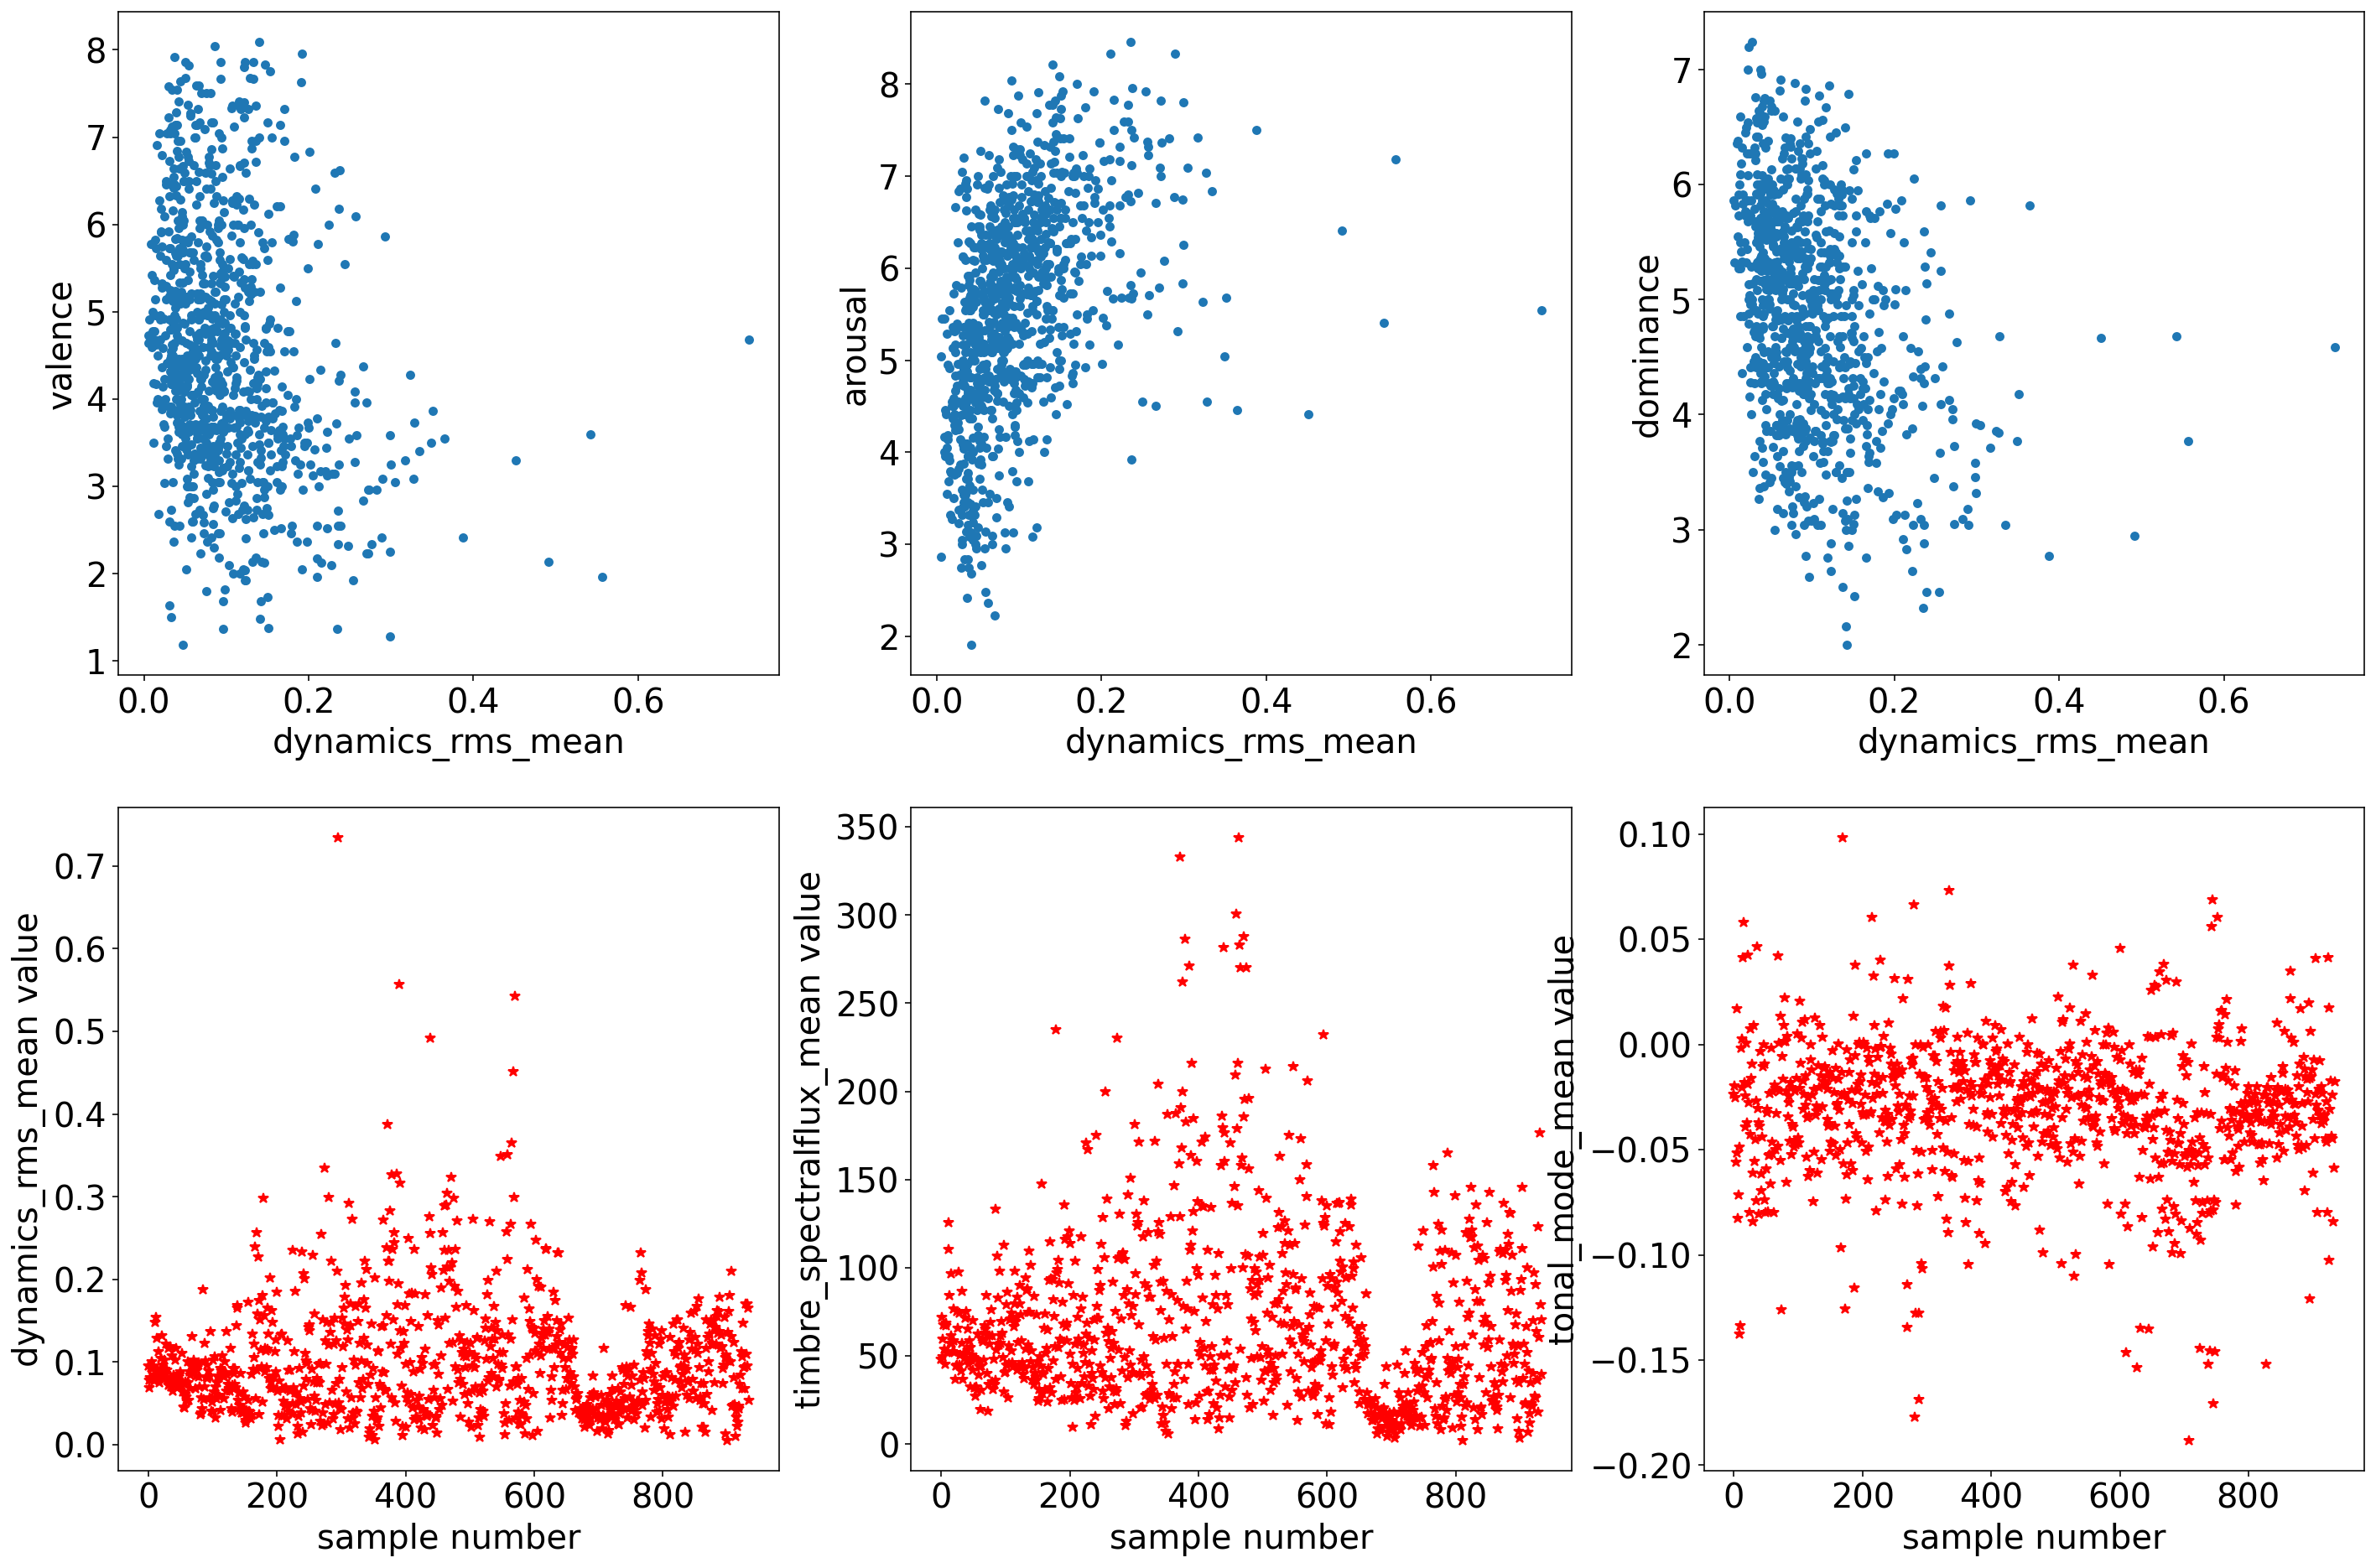

In [ ]:
fig, axes = plt.subplots(2,3, figsize=(24,16))
plt.rcParams['font.size'] = '16'
iadse.plot(ax=axes[0][0], kind='scatter', y='valence', x='dynamics_rms_mean');
iadse.plot(ax=axes[0][1], kind='scatter', y='arousal', x='dynamics_rms_mean');
iadse.plot(ax=axes[0][2], kind='scatter', y='dominance', x='dynamics_rms_mean');
iadse['dynamics_rms_mean'].plot(ax=axes[1][0], kind='line', style='*r',  xlabel='sample number', ylabel='dynamics_rms_mean value');
iadse['timbre_spectralflux_mean'].plot(ax=axes[1][1], kind='line', style='*r',   xlabel='sample number', ylabel='timbre_spectralflux_mean value');
iadse['tonal_mode_mean'].plot(ax=axes[1][2], kind='line', style='*r',  xlabel='sample number', ylabel='tonal_mode_mean value');


In [ ]:
iadse.columns

Index(['source', 'description', 'category', 'fname', 'BE_Classification',
       'arousal', 'valence', 'dominance', 'dynamics_rms_mean',
       'dynamics_rms_std', 'rhythm_attacktime_mean', 'rhythm_tempo_mean',
       'rhythm_tempo_std', 'rhythm_pulseclarity_mean',
       'rhythm_eventdensity_mean', 'rhythm_fluctuationmax_peakposmean',
       'spectral_centroid_mean', 'spectral_centroid_std',
       'spectral_brightness_mean', 'spectral_brightness_std',
       'spectral_spread_mean', 'spectral_spread_std', 'spectral_skewness_mean',
       'spectral_skewness_std', 'spectral_kurtosis_mean',
       'spectral_kurtosis_std', 'spectral_rolloff95_mean',
       'spectral_rolloff95_std', 'spectral_rolloff85_mean',
       'spectral_rolloff85_std', 'spectral_spectentropy_mean',
       'spectral_spectentropy_std', 'spectral_flatness_mean',
       'spectral_flatness_std', 'spectral_novelty_mean',
       'spectral_novelty_std', 'spectral_roughness_mean',
       'spectral_irregularity_mean', 'spectra

In [ ]:
iadse.shape

(935, 76)

In [ ]:
iadse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 935 entries, 0 to 934
Data columns (total 76 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   source                             935 non-null    object 
 1   description                        935 non-null    object 
 2   category                           935 non-null    object 
 3   fname                              935 non-null    object 
 4   BE_Classification                  935 non-null    object 
 5   arousal                            935 non-null    float64
 6   valence                            935 non-null    float64
 7   dominance                          935 non-null    float64
 8   dynamics_rms_mean                  935 non-null    float64
 9   dynamics_rms_std                   935 non-null    float64
 10  rhythm_attacktime_mean             935 non-null    float64
 11  rhythm_tempo_mean                  934 non-null    float64

In [ ]:
# Get all the columns which have missing values
iad_null_count = iadse.isnull().sum()
iad_null_count[iad_null_count > 0].sort_values(ascending = False)

tonal_keyclarity_mean    6
tonal_keyclarity_std     6
tonal_mode_std           6
tonal_hcdf_std           6
rhythm_tempo_std         2
rhythm_tempo_mean        1
dtype: int64

In [ ]:
# Find rows with NaN values.
iadse[iadse['tonal_keyclarity_mean'].isnull() == True]

,source,description,category,fname,BE_Classification,arousal,valence,dominance,dynamics_rms_mean,dynamics_rms_std,...,timbre_lowenergy_std,timbre_spectralflux_mean,timbre_spectralflux_std,pitch_pitch_mean,tonal_keyclarity_mean,tonal_keyclarity_std,tonal_mode_mean,tonal_mode_std,tonal_hcdf_mean,tonal_hcdf_std
194,Expanded,Cicada1,Animals,258,H,2.958333,7.166667,6.29,0.083655,0.055079,...,2.561044,66.924105,47.355112,736.240107,NaN,NaN,0.0,NaN,0.0,NaN
282,Expanded,Electronic Sound28,Electric sound,381,FS,5.375000,3.541667,4.50,0.050478,0.054255,...,3.257931,41.547135,46.396113,461.090760,NaN,NaN,0.0,NaN,0.0,NaN
290,Expanded,Bells4,Daily Routine Sound,405,FH,5.363636,4.909091,5.59,0.153546,0.127678,...,2.915270,141.138008,115.415761,283.275792,NaN,NaN,0.0,NaN,0.0,NaN
388,Expanded,Electronic Sound36,Electric sound,629,F,7.083333,3.458333,4.13,0.169569,0.183197,...,2.338268,112.838724,198.936355,1939.624155,NaN,NaN,0.0,NaN,0.0,NaN
574,Expanded,Alarm4,Daily Routine Sound,1007,U,5.772727,4.000000,5.45,0.073163,0.039918,...,2.588918,73.530658,38.904905,280.139266,NaN,NaN,0.0,NaN,0.0,NaN
578,Expanded,Effectsound3,Sound Effect,1021,F,4.500000,4.363636,5.14,0.053719,0.017681,...,1.298736,46.248385,33.106449,915.159922,NaN,NaN,0.0,NaN,0.0,NaN


In [ ]:
# All rows with missing values
iadse[iadse['tonal_keyclarity_mean'].isnull()].index

Int64Index([194, 282, 290, 388, 574, 578], dtype='int64')

In [ ]:
iadse[iadse['rhythm_tempo_std'].isnull()].index

Int64Index([412, 538], dtype='int64')

In [ ]:
iadse[iadse['rhythm_tempo_mean'].isnull()].index

Int64Index([412], dtype='int64')

In [ ]:
# Drop the rows with null values
iadse = iadse.dropna(how='any',axis=0)

In [ ]:
# Check again, there are no more null values left.
iad_null_count = iadse.isnull().sum()
iad_null_count[iad_null_count > 0].sort_values(ascending=False)

Series([], dtype: int64)

In [ ]:
# Normalize all the columns in iadsed dataset
# Mean Normalization
num_cols_iadse = list(iadse.select_dtypes(include=[np.number]).columns.values)
num_cols_iadse.remove('arousal')
num_cols_iadse.remove('valence')
num_cols_iadse.remove('dominance')
normalized_iadse = iadse.copy()
normalized_iadse[num_cols_iadse] = (iadse[num_cols_iadse]-iadse[num_cols_iadse].mean())/iadse[num_cols_iadse].std()
normalized_iadse.head()

,source,description,category,fname,BE_Classification,arousal,valence,dominance,dynamics_rms_mean,dynamics_rms_std,...,timbre_lowenergy_std,timbre_spectralflux_mean,timbre_spectralflux_std,pitch_pitch_mean,tonal_keyclarity_mean,tonal_keyclarity_std,tonal_mode_mean,tonal_mode_std,tonal_hcdf_mean,tonal_hcdf_std
0,Expanded,LightMusic24,Music,1,H,4.181818,6.545455,5.73,-0.082108,-0.469829,...,-1.280346,-0.403920,-0.692948,-0.290785,-0.213993,-0.743743,0.229554,0.121834,-0.532684,-0.700314
1,Expanded,Sci-Fi4,Sound Effect,2,F,6.181818,3.227273,3.55,-0.320277,-0.540925,...,0.320994,0.064848,-0.425820,0.080045,0.490931,-0.064776,0.350161,1.667465,0.524315,-0.701383
2,Expanded,Suspense Thriller1,Sound Effect,3,FS,5.227273,4.227273,4.23,-0.443299,-0.569338,...,-0.230177,-0.375960,-0.608755,-0.204908,-0.054575,0.128546,0.178540,-1.644607,-0.912458,-0.926082
3,Expanded,Suspense Thriller2,Sound Effect,0003_b,FS,5.500000,4.500000,4.86,-0.274068,-0.350478,...,-0.012543,-0.177638,-0.425296,-0.186991,1.166817,-1.090091,-0.745491,0.005058,-0.361225,-0.976738
4,Expanded,HorrorFilm7,Sound Effect,4,F,6.541667,4.208333,3.88,-0.112160,-0.885049,...,-1.460083,-0.016679,-0.855976,-0.437394,-0.020493,-0.572520,1.461637,1.091575,-0.368208,-1.054452


In [ ]:
#Min Max Normalization
normalized_iadse_min_max = iadse.copy()
normalized_iadse_min_max[num_cols_iadse] = (iadse[num_cols_iadse]-iadse[num_cols_iadse].min())/(iadse[num_cols_iadse].max() - iadse[num_cols_iadse].min())
normalized_iadse_min_max.head()

,source,description,category,fname,BE_Classification,arousal,valence,dominance,dynamics_rms_mean,dynamics_rms_std,...,timbre_lowenergy_std,timbre_spectralflux_mean,timbre_spectralflux_std,pitch_pitch_mean,tonal_keyclarity_mean,tonal_keyclarity_std,tonal_mode_mean,tonal_mode_std,tonal_hcdf_mean,tonal_hcdf_std
0,Expanded,LightMusic24,Music,1,H,4.181818,6.545455,5.73,0.122978,0.117740,...,0.335939,0.134705,0.070679,0.206011,0.516918,0.286804,0.574507,0.508362,0.167402,0.218309
1,Expanded,Sci-Fi4,Sound Effect,2,F,6.181818,3.227273,3.55,0.099422,0.107828,...,0.645832,0.203858,0.106516,0.252204,0.635515,0.398061,0.588421,0.742350,0.298491,0.218103
2,Expanded,Suspense Thriller1,Sound Effect,3,FS,5.227273,4.227273,4.23,0.087254,0.103867,...,0.539169,0.138830,0.081974,0.216708,0.543738,0.429740,0.568621,0.240946,0.120302,0.174737
3,Expanded,Suspense Thriller2,Sound Effect,0003_b,FS,5.500000,4.500000,4.86,0.103992,0.134379,...,0.581285,0.168087,0.106586,0.218940,0.749226,0.230050,0.462012,0.490683,0.188666,0.164961
4,Expanded,HorrorFilm7,Sound Effect,4,F,6.541667,4.208333,3.88,0.120006,0.059853,...,0.301156,0.191831,0.048808,0.187749,0.549472,0.314861,0.716657,0.655168,0.187800,0.149962


<a name='load_data'></a>

### 2.2 IADSE Dataset Training

---


In [ ]:
#Splitting the data into train and test sets after shuffling
iadse_shuffled = shuffle(normalized_iadse_min_max)
X_iadse = iadse_shuffled.iloc[:,8:]
Y_iadse = iadse_shuffled.iloc[:,5:8]

X_iadse_train, X_iadse_test, Y_iadse_train, Y_iadse_test,  = train_test_split(X_iadse, Y_iadse, test_size=0.2, random_state=0)

<a name='Train'></a>

#### 2.2.1 Linear Regression


In [ ]:
#Fitting Linear Regression to training set
regressor_iadse_Linear_arousal = LinearRegression()
regressor_iadse_Linear_valence = LinearRegression()
regressor_iadse_Linear_dominance = LinearRegression()

regressor_iadse_Linear_arousal.fit(X_iadse_train, Y_iadse_train.iloc[:,0])
regressor_iadse_Linear_valence.fit(X_iadse_train, Y_iadse_train.iloc[:,1])
regressor_iadse_Linear_dominance.fit(X_iadse_train, Y_iadse_train.iloc[:,2])

#Making prediction on the test set using Linear Regression Model
Y_iadse_pred_Linear_arousal = regressor_iadse_Linear_arousal.predict(X_iadse_test)
Y_iadse_pred_Linear_valence = regressor_iadse_Linear_valence.predict(X_iadse_test)
Y_iadse_pred_Linear_dominance = regressor_iadse_Linear_dominance.predict(X_iadse_test)

#Making prediction on the training set using Linear Regression Model
Y_iadse_pred_Linear_arousal_train = regressor_iadse_Linear_arousal.predict(X_iadse_train)
Y_iadse_pred_Linear_valence_train = regressor_iadse_Linear_valence.predict(X_iadse_train)
Y_iadse_pred_Linear_dominance_train = regressor_iadse_Linear_dominance.predict(X_iadse_train)

In [ ]:
#Calculating RMSE for Linear Regression Model

MSE_iadse_LR_arousal = mean_squared_error(np.array(Y_iadse_test)[:,0], Y_iadse_pred_Linear_arousal)
RMSE_iadse_LR_arousal = math.sqrt(MSE_iadse_LR_arousal)
print("RMSE for arousal in IADSE (Linear Regression) on Test Set :",RMSE_iadse_LR_arousal)

MSE_iadse_LR_arousal_train = mean_squared_error(np.array(Y_iadse_train)[:,0], Y_iadse_pred_Linear_arousal_train)
RMSE_iadse_LR_arousal_train = math.sqrt(MSE_iadse_LR_arousal_train)
print("RMSE for arousal in IADSE (Linear Regression) on Training Set :",RMSE_iadse_LR_arousal_train)

MSE_iadse_LR_valence = mean_squared_error(np.array(Y_iadse_test)[:,1], Y_iadse_pred_Linear_valence)
RMSE_iadse_LR_valence = math.sqrt(MSE_iadse_LR_valence)
print("RMSE for valence in IADSE (Linear Regression) on Test Set:",RMSE_iadse_LR_valence)

MSE_iadse_LR_valence_train = mean_squared_error(np.array(Y_iadse_train)[:,1], Y_iadse_pred_Linear_valence_train)
RMSE_iadse_LR_valence_train = math.sqrt(MSE_iadse_LR_valence_train)
print("RMSE for valence in IADSE (Linear Regression) on Training Set:",RMSE_iadse_LR_valence_train)

MSE_iadse_LR_dominance = mean_squared_error(np.array(Y_iadse_test)[:,2], Y_iadse_pred_Linear_dominance)
RMSE_iadse_LR_dominance = math.sqrt(MSE_iadse_LR_dominance)
print("RMSE for dominance in IADSE (Linear Regression) on Test Set:",RMSE_iadse_LR_dominance)

MSE_iadse_LR_dominance_train = mean_squared_error(np.array(Y_iadse_train)[:,2], Y_iadse_pred_Linear_dominance_train)
RMSE_iadse_LR_dominance_train = math.sqrt(MSE_iadse_LR_dominance_train)
print("RMSE for dominance in IADSE (Linear Regression) on Training Set:",RMSE_iadse_LR_dominance_train)

RMSE for arousal in IADSE (Linear Regression) on Test Set : 0.9028770076463419
RMSE for arousal in IADSE (Linear Regression) on Training Set : 0.7490055595904352
RMSE for valence in IADSE (Linear Regression) on Test Set: 1.1422424523322552
RMSE for valence in IADSE (Linear Regression) on Training Set: 1.081867903255074
RMSE for dominance in IADSE (Linear Regression) on Test Set: 0.8774065793894066
RMSE for dominance in IADSE (Linear Regression) on Training Set: 0.7721484569772221


<a name='Train'></a>

#### 2.2.1 Polynomial Regression


In [ ]:
#Training Polynomial Models

polyreg_iadse = PolynomialFeatures(degree=3)

#Generating the polynomial feature
X_poly_iadse = polyreg_iadse.fit_transform(X_iadse_train)

#Training the polynomial model
poly_reg_iadse_arousal = LinearRegression()
poly_reg_iadse_arousal.fit(X_poly_iadse, Y_iadse_train.iloc[:,0])

poly_reg_iadse_valence = LinearRegression()
poly_reg_iadse_valence.fit(X_poly_iadse, Y_iadse_train.iloc[:,1])

poly_reg_iadse_dominance = LinearRegression()
poly_reg_iadse_dominance.fit(X_poly_iadse, Y_iadse_train.iloc[:,2])

#Generating polynomial features for test set
X_iadse_test_poly = polyreg_iadse.transform(X_iadse_test)

In [ ]:
#Making Predictions
y_pred_arousal_poly_iadse = poly_reg_iadse_arousal.predict(X_iadse_test_poly)
y_pred_valence_poly_iadse = poly_reg_iadse_valence.predict(X_iadse_test_poly)
y_pred_dominance_poly_iadse = poly_reg_iadse_dominance.predict(X_iadse_test_poly)
y_pred_arousal_poly_iadse_train = poly_reg_iadse_arousal.predict(X_poly_iadse)
y_pred_valence_poly_iadse_train = poly_reg_iadse_valence.predict(X_poly_iadse)
y_pred_dominance_poly_iadse_train = poly_reg_iadse_dominance.predict(X_poly_iadse)

In [ ]:
#RMSE of "arousal" for training set (Training error)
MSE_Poly_arousal_train_iadse = mean_squared_error(np.array(Y_iadse_train)[:,0], y_pred_arousal_poly_iadse_train)
RMSE_Poly_arousal_train_iadse = math.sqrt(MSE_Poly_arousal_train_iadse)
print("Training error: RMSE for arousal in IADSE (Linear Regression (degree 3)) :",RMSE_Poly_arousal_train_iadse)

#RMSE of "arousal" for testing set (test error)
MSE_Poly_arousal_test_iadse = mean_squared_error(np.array(Y_iadse_test)[:,0], y_pred_arousal_poly_iadse)
RMSE_Poly_arousal_test_iadse = math.sqrt(MSE_Poly_arousal_test_iadse)
print("Test error: RMSE for arousal in IADSE (Linear Regression (degree 3)) :    ",RMSE_Poly_arousal_test_iadse)

#RMSE of "valence" for training set (Training error)
MSE_Poly_valence_train_iadse = mean_squared_error(np.array(Y_iadse_train)[:,1], y_pred_valence_poly_iadse_train)
RMSE_Poly_valence_train_iadse = math.sqrt(MSE_Poly_valence_train_iadse)
print("Training error: RMSE for valence in IADSE (Linear Regression (degree 3)) :",RMSE_Poly_valence_train_iadse)

#RMSE of "valence" for testing set (test error)
MSE_Poly_valence_test_iadse = mean_squared_error(np.array(Y_iadse_test)[:,1], y_pred_valence_poly_iadse)
RMSE_Poly_valence_test_iadse = math.sqrt(MSE_Poly_valence_test_iadse)
print("Test error: RMSE for valence in IADSE (Linear Regression (degree 3)) :    ",RMSE_Poly_valence_test_iadse)

#RMSE of "dominance" for training set (Training error)
MSE_Poly_dominance_train_iadse = mean_squared_error(np.array(Y_iadse_train)[:,2], y_pred_dominance_poly_iadse_train)
RMSE_Poly_dominance_train_iadse = math.sqrt(MSE_Poly_dominance_train_iadse)
print("Training error: RMSE for dominance in IADSE (Linear Regression (degree 3)) :",RMSE_Poly_dominance_train_iadse)

#RMSE of "domiance" for testing set (test error)
MSE_Poly_dominance_test_iadse = mean_squared_error(np.array(Y_iadse_test)[:,2], y_pred_dominance_poly_iadse)
RMSE_Poly_dominance_test_iadse = math.sqrt(MSE_Poly_dominance_test_iadse)
print("Test error: RMSE for dominance in IADSE (Linear Regression (degree 3)) :    ",RMSE_Poly_dominance_test_iadse)

Training error: RMSE for arousal in IADSE (Linear Regression (degree 3)) : 1.6557877218075222e-14
Test error: RMSE for arousal in IADSE (Linear Regression (degree 3)) :     1.712248676468817
Training error: RMSE for valence in IADSE (Linear Regression (degree 3)) : 1.7076130210546418e-14
Test error: RMSE for valence in IADSE (Linear Regression (degree 3)) :     3.266526723902954
Training error: RMSE for dominance in IADSE (Linear Regression (degree 3)) : 1.3092103974663734e-14
Test error: RMSE for dominance in IADSE (Linear Regression (degree 3)) :     2.7817908274390644


In [ ]:
#reducing the polynomial function to degree 2
polyreg_iadse2 = PolynomialFeatures(degree=2)

#Generating the polynomial feature
X_poly_iadse2 = polyreg_iadse2.fit_transform(X_iadse_train)

#Training the polynomial model
poly_reg_iadse_arousal2 = LinearRegression()
poly_reg_iadse_arousal2.fit(X_poly_iadse2, Y_iadse_train.iloc[:,0])

poly_reg_iadse_valence2 = LinearRegression()
poly_reg_iadse_valence2.fit(X_poly_iadse2, Y_iadse_train.iloc[:,1])

poly_reg_iadse_dominance2 = LinearRegression()
poly_reg_iadse_dominance2.fit(X_poly_iadse2, Y_iadse_train.iloc[:,2])

#Generating polynomial features for test set
X_iadse_test_poly2 = polyreg_iadse2.transform(X_iadse_test)

In [ ]:
#Making Predictions
y_pred_arousal_poly_iadse2 = poly_reg_iadse_arousal2.predict(X_iadse_test_poly2)
y_pred_valence_poly_iadse2 = poly_reg_iadse_valence2.predict(X_iadse_test_poly2)
y_pred_dominance_poly_iadse2 = poly_reg_iadse_dominance2.predict(X_iadse_test_poly2)
y_pred_arousal_poly_iadse_train2 = poly_reg_iadse_arousal2.predict(X_poly_iadse2)
y_pred_valence_poly_iadse_train2 = poly_reg_iadse_valence2.predict(X_poly_iadse2)
y_pred_dominance_poly_iadse_train2 = poly_reg_iadse_dominance2.predict(X_poly_iadse2)

In [ ]:
#RMSE of "arousal" for training set (Training error)
MSE_Poly_arousal_train_iadse2 = mean_squared_error(np.array(Y_iadse_train)[:,0], y_pred_arousal_poly_iadse_train2)
RMSE_Poly_arousal_train_iadse2 = math.sqrt(MSE_Poly_arousal_train_iadse2)
print("Training error: RMSE for arousal in IADSE (Linear Regression (degree 2)) :",RMSE_Poly_arousal_train_iadse2)

#RMSE of "arousal" for testing set (test error)
MSE_Poly_arousal_test_iadse2 = mean_squared_error(np.array(Y_iadse_test)[:,0], y_pred_arousal_poly_iadse2)
RMSE_Poly_arousal_test_iadse2 = math.sqrt(MSE_Poly_arousal_test_iadse2)
print("Test error: RMSE for arousal in IADSE (Linear Regression (degree 2)) :    ",RMSE_Poly_arousal_test_iadse2)

#RMSE of "valence" for training set (Training error)
MSE_Poly_valence_train_iadse2 = mean_squared_error(np.array(Y_iadse_train)[:,1], y_pred_valence_poly_iadse_train2)
RMSE_Poly_valence_train_iadse2 = math.sqrt(MSE_Poly_valence_train_iadse2)
print("Training error: RMSE for valence in IADSE (Linear Regression (degree 2)) :",RMSE_Poly_valence_train_iadse2)

#RMSE of "valence" for testing set (test error)
MSE_Poly_valence_test_iadse2 = mean_squared_error(np.array(Y_iadse_test)[:,1], y_pred_valence_poly_iadse2)
RMSE_Poly_valence_test_iadse2 = math.sqrt(MSE_Poly_valence_test_iadse2)
print("Test error: RMSE for valence in IADSE (Linear Regression (degree 2)) :    ",RMSE_Poly_valence_test_iadse2)

#RMSE of "dominance" for training set (Training error)
MSE_Poly_dominance_train_iadse2 = mean_squared_error(np.array(Y_iadse_train)[:,2], y_pred_dominance_poly_iadse_train2)
RMSE_Poly_dominance_train_iadse2 = math.sqrt(MSE_Poly_dominance_train_iadse2)
print("Training error: RMSE for dominance in IADSE (Linear Regression (degree 2)) :",RMSE_Poly_dominance_train_iadse2)

#RMSE of "domiance" for testing set (test error)
MSE_Poly_dominance_test_iadse2 = mean_squared_error(np.array(Y_iadse_test)[:,2], y_pred_dominance_poly_iadse2)
RMSE_Poly_dominance_test_iadse2 = math.sqrt(MSE_Poly_dominance_test_iadse2)
print("Test error: RMSE for dominance in IADSE (Linear Regression (degree 2)) :    ",RMSE_Poly_dominance_test_iadse2)

Training error: RMSE for arousal in IADSE (Linear Regression (degree 2)) : 2.5866071470042283e-14
Test error: RMSE for arousal in IADSE (Linear Regression (degree 2)) :     2.2285870112047323
Training error: RMSE for valence in IADSE (Linear Regression (degree 2)) : 3.536431208024166e-14
Test error: RMSE for valence in IADSE (Linear Regression (degree 2)) :     5.645911061530806
Training error: RMSE for dominance in IADSE (Linear Regression (degree 2)) : 2.39434144837513e-14
Test error: RMSE for dominance in IADSE (Linear Regression (degree 2)) :     3.77771047358602


In [ ]:
#Regularization
from sklearn.linear_model import LassoCV

#Train model
#arousal
reg_poly2_model_arousal_iadse = LassoCV(alphas=np.arange(0, 1, 0.001), cv=5, n_jobs=-1)
reg_poly2_model_arousal_iadse.fit(X_poly_iadse2, Y_iadse_train.iloc[:,0])

#valence
reg_poly2_model_valence_iadse = LassoCV(alphas=np.arange(0, 1, 0.001), cv=5, n_jobs=-1)
reg_poly2_model_valence_iadse.fit(X_poly_iadse2, Y_iadse_train.iloc[:,1])

#dominance
reg_poly2_model_dominance_iadse = LassoCV(alphas=np.arange(0, 1, 0.001), cv=5, n_jobs=-1)
reg_poly2_model_dominance_iadse.fit(X_poly_iadse2, Y_iadse_train.iloc[:,2])

print("The optimum value of alpha for arousal prediction :",reg_poly2_model_arousal_iadse.alpha_)
print("The optimum value of alpha for valence prediction :",reg_poly2_model_valence_iadse.alpha_)
print("The optimum value of alpha for dominance prediction :",reg_poly2_model_dominance_iadse.alpha_)

The optimum value of alpha for arousal prediction : 0.001
The optimum value of alpha for valence prediction : 0.002
The optimum value of alpha for dominance prediction : 0.004


In [ ]:
#Making predictions for regularized polynomial function
#arousal
y_pred_regPoly2_test_arousal_iadse = reg_poly2_model_arousal_iadse.predict(X_iadse_test_poly2)
y_pred_regPoly2_train_arousal_iadse = reg_poly2_model_arousal_iadse.predict(X_poly_iadse2)

#valence
y_pred_regPoly2_test_valence_iadse = reg_poly2_model_valence_iadse.predict(X_iadse_test_poly2)
y_pred_regPoly2_train_valence_iadse = reg_poly2_model_valence_iadse.predict(X_poly_iadse2)

#dominance
y_pred_regPoly2_test_dominance_iadse = reg_poly2_model_dominance_iadse.predict(X_iadse_test_poly2)
y_pred_regPoly2_train_dominance_iadse = reg_poly2_model_dominance_iadse.predict(X_poly_iadse2)

In [ ]:
#RMSE of "arousal" for training set (Training error)
RMSE_reg_Poly_arousal_train2_iadse = math.sqrt(mean_squared_error(np.array(Y_iadse_train)[:,0], y_pred_regPoly2_train_arousal_iadse))
print("Training error: RMSE for arousal in IADSE (Linear Regression (degree 2)) :",RMSE_reg_Poly_arousal_train2_iadse)

#RMSE of "arousal" for testing set (test error)
RMSE_reg_Poly_arousal_test2_iadse = math.sqrt(mean_squared_error(np.array(Y_iadse_test)[:,0], y_pred_regPoly2_test_arousal_iadse))
print("Test error: RMSE for arousal in IADSE (Linear Regression (degree 2))     :",RMSE_reg_Poly_arousal_test2_iadse)

#RMSE of "valence" for training set (Training error)
RMSE_reg_Poly_valence_train2_iadse = math.sqrt(mean_squared_error(np.array(Y_iadse_train)[:,1], y_pred_regPoly2_train_valence_iadse))
print("Training error: RMSE for valence in IADSE (Linear Regression (degree 2)) :",RMSE_reg_Poly_valence_train2_iadse)

#RMSE of "valence" for testing set (test error)
RMSE_reg_Poly_valence_test2_iadse = math.sqrt(mean_squared_error(np.array(Y_iadse_test)[:,1], y_pred_regPoly2_test_valence_iadse))
print("Test error: RMSE for valence in IADSE (Linear Regression (degree 2))     :",RMSE_reg_Poly_valence_test2_iadse)

#RMSE of "dominance" for training set (Training error)
RMSE_reg_Poly_dominance_train2_iadse = math.sqrt(mean_squared_error(np.array(Y_iadse_train)[:,2], y_pred_regPoly2_train_dominance_iadse))
print("Training error: RMSE for dominance in IADSE (Linear Regression (degree 2)) :",RMSE_reg_Poly_dominance_train2_iadse)

#RMSE of "dominance" for testing set (test error)
RMSE_reg_Poly_dominance_test2_iadse = math.sqrt(mean_squared_error(np.array(Y_iadse_test)[:,2], y_pred_regPoly2_test_dominance_iadse))
print("Test error: RMSE for dominance in IADSE (Linear Regression (degree 2))     :",RMSE_reg_Poly_dominance_test2_iadse)

Training error: RMSE for arousal in IADSE (Linear Regression (degree 2)) : 0.6575959421692777
Test error: RMSE for arousal in IADSE (Linear Regression (degree 2))     : 0.8043173227853606
Training error: RMSE for valence in IADSE (Linear Regression (degree 2)) : 1.0420592691605126
Test error: RMSE for valence in IADSE (Linear Regression (degree 2))     : 1.0405661911109765
Training error: RMSE for dominance in IADSE (Linear Regression (degree 2)) : 0.8103460535462392
Test error: RMSE for dominance in IADSE (Linear Regression (degree 2))     : 0.8473603129113434


<a name='Train'></a>

#### 2.2.3 Random Forest Regression


In [ ]:
#getting validation sets
X_iadse_train, X_iadse_validate, Y_iadse_train, Y_iadse_validate,  = train_test_split(X_iadse_train, Y_iadse_train, test_size=0.25, random_state=0)

In [ ]:
#Training the Random Forest Model
reg_iadse_RF_arousal = RandomForestRegressor(n_estimators=50, random_state=0)
reg_iadse_RF_valence = RandomForestRegressor(n_estimators=50, random_state=0)
reg_iadse_RF_dominance = RandomForestRegressor(n_estimators=50, random_state=0)

reg_iadse_RF_arousal.fit(X_iadse_train, Y_iadse_train.iloc[:,0])
reg_iadse_RF_valence.fit(X_iadse_train, Y_iadse_train.iloc[:,1])
reg_iadse_RF_dominance.fit(X_iadse_train, Y_iadse_train.iloc[:,2])


RandomForestRegressor(n_estimators=50, random_state=0)

In [ ]:
#Making predictions on training and validation set using Random Forest

Y_iadse_pred_RF_arousal_train = reg_iadse_RF_arousal.predict(X_iadse_train)
Y_iadse_pred_RF_valence_train = reg_iadse_RF_valence.predict(X_iadse_train)
Y_iadse_pred_RF_dominance_train = reg_iadse_RF_dominance.predict(X_iadse_train)

Y_iadse_pred_RF_arousal_valid = reg_iadse_RF_arousal.predict(X_iadse_validate)
Y_iadse_pred_RF_valence_valid = reg_iadse_RF_valence.predict(X_iadse_validate)
Y_iadse_pred_RF_dominance_valid = reg_iadse_RF_dominance.predict(X_iadse_validate)

In [ ]:
#Calculating the RMSE for Random Forest on validation set
print("RMSE for arousal in IADSE (Random Forest) :",math.sqrt(mean_squared_error(np.array(Y_iadse_validate)[:,0], Y_iadse_pred_RF_arousal_valid)))

print("RMSE for valence in IADSE (Random Forest) :",math.sqrt(mean_squared_error(np.array(Y_iadse_validate)[:,1], Y_iadse_pred_RF_valence_valid)))

print("RMSE for dominance in IADSE (Random Forest) :",math.sqrt(mean_squared_error(np.array(Y_iadse_validate)[:,2], Y_iadse_pred_RF_dominance_valid)))

RMSE for arousal in IADSE (Random Forest) : 0.8111543128893908
RMSE for valence in IADSE (Random Forest) : 1.1637375804229841
RMSE for dominance in IADSE (Random Forest) : 0.8674918968974845


In [ ]:
#Calculating the RMSE for Random Forest on training set
print("RMSE for arousal in IADSE (Random Forest) :",math.sqrt(mean_squared_error(np.array(Y_iadse_train)[:,0], Y_iadse_pred_RF_arousal_train)))

print("RMSE for valence in IADSE (Random Forest) :",math.sqrt(mean_squared_error(np.array(Y_iadse_train)[:,1], Y_iadse_pred_RF_valence_train)))

print("RMSE for dominance in IADSE (Random Forest) :",math.sqrt(mean_squared_error(np.array(Y_iadse_train)[:,2], Y_iadse_pred_RF_dominance_train)))

RMSE for arousal in IADSE (Random Forest) : 0.28526490603470717
RMSE for valence in IADSE (Random Forest) : 0.437757596132683
RMSE for dominance in IADSE (Random Forest) : 0.32125777351691437


In [ ]:
#Making predictions on test set
Y_iadse_pred_RF_arousal_test = reg_iadse_RF_arousal.predict(X_iadse_test)
Y_iadse_pred_RF_valence_test = reg_iadse_RF_valence.predict(X_iadse_test)
Y_iadse_pred_RF_dominance_test = reg_iadse_RF_dominance.predict(X_iadse_test)

In [ ]:
#Calculating the RMSE for Random Forest on test set
print("RMSE for arousal in IADSE (Random Forest) :",math.sqrt(mean_squared_error(np.array(Y_iadse_test)[:,0], Y_iadse_pred_RF_arousal_test)))

print("RMSE for valence in IADSE (Random Forest) :",math.sqrt(mean_squared_error(np.array(Y_iadse_test)[:,1], Y_iadse_pred_RF_valence_test)))

print("RMSE for dominance in IADSE (Random Forest) :",math.sqrt(mean_squared_error(np.array(Y_iadse_test)[:,2], Y_iadse_pred_RF_dominance_test)))

RMSE for arousal in IADSE (Random Forest) : 0.7626426984517436
RMSE for valence in IADSE (Random Forest) : 1.0747719705183212
RMSE for dominance in IADSE (Random Forest) : 0.7987692164043811


<a name='Cross Validation'></a>

### 2.3 IADSE Dataset 5-fold cross validation


In [ ]:
#5-Fold Cross Validation for IADSE Dataset

X_iadse = normalized_iadse_min_max.iloc[:,8:]
Y_iadse = normalized_iadse_min_max.iloc[:,5:8]

#Linear Regression
lr_cv_arousal_iadse = LinearRegression()
rmse_cv_linear_arousal_iadse = cross_validate(5, X_iadse, Y_iadse.iloc[:,0], lr_cv_arousal_iadse)
print("RMSE for each fold of Linear Regression Model (arousal) IADSE ",rmse_cv_linear_arousal_iadse)
print("Average RMSE (arousal) IADSE ",np.mean(rmse_cv_linear_arousal_iadse))

lr_cv_valence_iadse = LinearRegression()
rmse_cv_linear_valence_iadse = cross_validate(5, X_iadse, Y_iadse.iloc[:,1], lr_cv_valence_iadse)
print("RMSE for each fold of Linear Regression Model (valence) ",rmse_cv_linear_valence_iadse)
print("Average RMSE (valence) ",np.mean(rmse_cv_linear_valence_iadse))

lr_cv_dominance_iadse = LinearRegression()
rmse_cv_linear_dominance_iadse = cross_validate(5, X_iadse, Y_iadse.iloc[:,2], lr_cv_dominance_iadse)
print("RMSE for each fold of Linear Regression Model (dominance) ",rmse_cv_linear_dominance_iadse)
print("Average RMSE (dominance) ",np.mean(rmse_cv_linear_dominance_iadse))

RMSE for each fold of Linear Regression Model (arousal) IADSE  [0.8534881487714262, 0.842829856830934, 0.8490984493216416, 0.8507112773380551, 0.8704663199676943]
Average RMSE (arousal) IADSE  0.8533188104459504
RMSE for each fold of Linear Regression Model (valence)  [1.147049141017769, 1.0930548596331593, 1.2593132023337308, 1.2469935503001677, 1.1840782625574298]
Average RMSE (valence)  1.1860978031684513
RMSE for each fold of Linear Regression Model (dominance)  [0.8439968789639556, 0.8491421301936831, 0.8946924628052593, 0.9171220708031921, 0.7848016017381219]
Average RMSE (dominance)  0.8579510289008423


In [ ]:
#Random Forest arousal
rf_cv_arousal_iadse = RandomForestRegressor(n_estimators=50, random_state=2)
rmse_cv_rf_arousal_iadse = cross_validate(5, X_iadse, Y_iadse.iloc[:,0], rf_cv_arousal_iadse)
print("RMSE for each fold of Random Forest Regression Model (arousal) ",rmse_cv_rf_arousal_iadse)
print("Average RMSE (arousal) ",np.mean(rmse_cv_rf_arousal))

#Random Forest valence
rf_cv_valence_iadse = RandomForestRegressor(n_estimators=50, random_state=5)
rmse_cv_rf_valence_iadse = cross_validate(5, X_iadse, Y_iadse.iloc[:,1], rf_cv_valence_iadse)
print("RMSE for each fold of Random Forest Regression Model (valence) ",rmse_cv_rf_valence_iadse)
print("Average RMSE (valence) ",np.mean(rmse_cv_rf_valence_iadse))

#Random Forest dominance
rf_cv_valence_iadse = RandomForestRegressor(n_estimators=50, random_state=5)
rmse_cv_rf_valence_iadse = cross_validate(5, X_iadse, Y_iadse.iloc[:,2], rf_cv_valence_iadse)
print("RMSE for each fold of Random Forest Regression Model (dominance) ",rmse_cv_rf_valence_iadse)
print("Average RMSE (dominance) ",np.mean(rmse_cv_rf_valence_iadse))

RMSE for each fold of Random Forest Regression Model (arousal)  [0.7997465827613717, 0.7868213006581749, 0.7882718324418833, 0.7558582106927795, 0.7889440950854718]
Average RMSE (arousal)  0.23551509437155066
RMSE for each fold of Random Forest Regression Model (valence)  [1.1399858971981758, 1.0607002543430026, 1.0774108169791228, 1.1355354131907058, 1.1225485816855554]
Average RMSE (valence)  1.1072361926793124
RMSE for each fold of Random Forest Regression Model (dominance)  [0.8388823097892929, 0.829158476492754, 0.8589500167316158, 0.8583202999447802, 0.7306887077789526]
Average RMSE (dominance)  0.8231999621474791


<a name='Feature selection'></a>

### 2.4 Feature selection


<a name='Filter method'></a>

#### 2.4.1 Filter method


Preprocessing part of the filter method.

In [ ]:
# shuffle the dataset and split into training/test sets ---- 80% 20%
iadse_shuffled = shuffle(normalized_iadse_min_max)

X_iadse = iadse_shuffled.iloc[:,8:]
y_iadse = iadse_shuffled.iloc[:,5:8]

X_iadse_train, X_iadse_test, y_iadse_train, y_iadse_test,  = train_test_split(X_iadse, y_iadse, test_size=0.2, random_state=0)

In [ ]:
# Removing Constant features using VarianceThreshold
from sklearn.feature_selection import VarianceThreshold

constant_filter = VarianceThreshold(threshold=0)

#Fit and transforming on train data
data_constant = constant_filter.fit_transform(X_iadse_train)

#Extracting all constant columns using get support function of our filter
constant_columns = [column for column in X_iadse_train.columns
                   if column not in X_iadse_train.columns[constant_filter.get_support()]]

#No. of constant columns
print(len(constant_columns))
print("No constant features were found.")

0
No constant features were found.


In [ ]:
# Removing Quasi-Constant Features

qcons_filter = VarianceThreshold(threshold=0.01)

#Fitand transforming on train data
data_qcons = qcons_filter.fit_transform(X_iadse_train)

#Extracting all Quasi constant columns using get support function of our filter
qcons_columns = [column for column in X_iadse_train.columns
                    if column not in X_iadse_train.columns[qcons_filter.get_support()]]

#No. of Quasi constant columns
print(len(qcons_columns)) 
print(f'{len(qcons_columns)} quasi-constant features were found.')

#Removing identified quasi-constant columns
X_iadse_train1 = X_iadse_train.drop(qcons_columns,axis=1)
X_iadse_test1 = X_iadse_test.drop(qcons_columns,axis=1)
print(X_iadse_train1.shape)
print(X_iadse_test1.shape)

31
31 quasi-constant features were found.
(741, 37)
(186, 37)


<a name='Training with selected features'></a>

##### 2.4.1.1  Linear Regression

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# feature selection
def select_features(X_train, y_train, X_test, num):
	# configure to select "num" features
	fs = SelectKBest(score_func=f_regression, k=num)
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

In [ ]:
## Arousal

# Select K best features, change "num" to get the best results.
X_iadse_arousal_train_filter, X_iadse_arousal_test_filter, fs_iadse = select_features(X_iadse_train1, y_iadse_train.iloc[:, 0], X_iadse_test1, 30)

# Fitting Linear Regression to training set
lr_arousal_filter = LinearRegression()
lr_arousal_filter.fit(X_iadse_arousal_train_filter, y_iadse_train.iloc[:, 0])

# Making predictions 
y_iadse_pred_lr_arousal_train_filter = lr_arousal_filter.predict(X_iadse_arousal_train_filter) # Train set
y_iadse_pred_lr_arousal_test_filter = lr_arousal_filter.predict(X_iadse_arousal_test_filter) # Test set

# Calculating the RMSE
# Training set (Training error)
MSE_lr_arousal_train_filter = mean_squared_error(np.array(y_iadse_train)[:,0], y_iadse_pred_lr_arousal_train_filter)
RMSE_lr_arousal_train_filter = math.sqrt(MSE_lr_arousal_train_filter)
print("Training error/RMSE for arousal in IADSE (Linear Regression) with filtered features:",RMSE_lr_arousal_train_filter)

# Testing set (test error)
MSE_lr_arousal_test_filter = mean_squared_error(np.array(y_iadse_test)[:,0], y_iadse_pred_lr_arousal_test_filter)
RMSE_lr_arousal_test_filter = math.sqrt(MSE_lr_arousal_test_filter)
print("Test error/RMSE for arousal in IADSE (Linear Regression) with filtered features:    ",RMSE_lr_arousal_test_filter)

Training error/RMSE for arousal in IADSE (Linear Regression) with filtered features: 0.8086216085378833
Test error/RMSE for arousal in IADSE (Linear Regression) with filtered features:     0.9026550395769951


In [ ]:
## valence

# Select K best features, change "num" to get the best results.
X_iadse_valence_train_filter, X_iadse_valence_test_filter, fs_iadse = select_features(X_iadse_train1, y_iadse_train.iloc[:, 1], X_iadse_test1, 16)

# Fitting Linear Regression to training set
lr_valence_filter = LinearRegression()
lr_valence_filter.fit(X_iadse_valence_train_filter, y_iadse_train.iloc[:, 1])

# Making predictions 
y_iadse_pred_lr_valence_train_filter = lr_valence_filter.predict(X_iadse_valence_train_filter) # Train set
y_iadse_pred_lr_valence_test_filter = lr_valence_filter.predict(X_iadse_valence_test_filter) # Test set

# Calculating the RMSE
# Training set (Training error)
MSE_lr_valence_train_filter = mean_squared_error(np.array(y_iadse_train)[:,1], y_iadse_pred_lr_valence_train_filter)
RMSE_lr_valence_train_filter = math.sqrt(MSE_lr_valence_train_filter)
print("Training error/RMSE for valence in IADSE (Linear Regression) with filtered features:",RMSE_lr_valence_train_filter)

# Testing set (test error)
MSE_lr_valence_test_filter = mean_squared_error(np.array(y_iadse_test)[:,1], y_iadse_pred_lr_valence_test_filter)
RMSE_lr_valence_test_filter = math.sqrt(MSE_lr_valence_test_filter)
print("Test error/RMSE for valence in IADSE (Linear Regression) with filtered features:    ",RMSE_lr_valence_test_filter)

Training error/RMSE for valence in IADSE (Linear Regression) with filtered features: 1.176791632841403
Test error/RMSE for valence in IADSE (Linear Regression) with filtered features:     1.112904590356534


In [ ]:
## dominance

# Select K best features, change "num" to get the best results.
X_iadse_dom_train_filter, X_iadse_dom_test_filter, fs_iadse = select_features(X_iadse_train1, y_iadse_train.iloc[:, 2], X_iadse_test1, 9)

# Fitting Linear Regression to training set
lr_dom_filter = LinearRegression()
lr_dom_filter.fit(X_iadse_dom_train_filter, y_iadse_train.iloc[:, 2])

# Making predictions 
y_iadse_pred_lr_dom_train_filter = lr_dom_filter.predict(X_iadse_dom_train_filter) # Train set
y_iadse_pred_lr_dom_test_filter = lr_dom_filter.predict(X_iadse_dom_test_filter) # Test set

# Calculating the RMSE
# Training set (Training error)
MSE_lr_dom_train_filter = mean_squared_error(np.array(y_iadse_train)[:,2], y_iadse_pred_lr_dom_train_filter)
RMSE_lr_dom_train_filter = math.sqrt(MSE_lr_dom_train_filter)
print("Training error/RMSE for dominance in IADSE (Linear Regression) with filtered features:",RMSE_lr_dom_train_filter)

# Testing set (test error)
MSE_lr_dom_test_filter = mean_squared_error(np.array(y_iadse_test)[:,2], y_iadse_pred_lr_dom_test_filter)
RMSE_lr_dom_test_filter = math.sqrt(MSE_lr_dom_test_filter)
print("Test error/RMSE for dominance in IADSE (Linear Regression) with filtered features:    ",RMSE_lr_dom_test_filter)

Training error/RMSE for dominance in IADSE (Linear Regression) with filtered features: 0.8342689876441052
Test error/RMSE for dominance in IADSE (Linear Regression) with filtered features:     0.8884958138286293


<a name='Training with selected features'></a>

##### 2.4.1.2  Random Forest Regression


In [ ]:
## Arousal

# Select K best features, change "num" to get the best results.
X_iadse_arousal_train_filter, X_iadse_arousal_test_filter, fs_iadse = select_features(X_iadse_train1, y_iadse_train.iloc[:, 0], X_iadse_test1, 29)

In [ ]:
#Use GridSearch to fine tune model

from sklearn.model_selection import GridSearchCV

rf_arousal_filter = RandomForestRegressor()
tune_paragm = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 50, 100],
    'min_samples_split': [2, 3, 5, 7],
    'min_samples_leaf': [1, 3, 5]
}
rf_gdcv_arousal_filter = GridSearchCV(rf_arousal_filter, tune_paragm, n_jobs=-1, cv=5)
rf_gdcv_arousal_filter.fit(X_iadse_arousal_train_filter, y_iadse_train.iloc[:, 0])

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [10, 50, 100],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 3, 5, 7],
                         'n_estimators': [50, 100, 150]})

In [ ]:
# Get the best parameters
rf_gdcv_arousal_filter.best_params_

# Save the seed
# num=29: max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100
# num=30: 'max_depth': 100,  'min_samples_leaf': 1,  'min_samples_split': 3,   'n_estimators': 150
# num=31: 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 50

{'max_depth': 50,
 'min_samples_leaf': 3,
 'min_samples_split': 7,
 'n_estimators': 50}

In [ ]:
# Create a regressor using best parameters
rf_arousal_filter = RandomForestRegressor(n_estimators=100, max_depth=50, min_samples_split=2, min_samples_leaf=1)
rf_arousal_filter.fit(X_iadse_arousal_train_filter, y_iadse_train.iloc[:, 0])

# Making predictions 
y_pred_rf_arousal_train_filter = rf_arousal_filter.predict(X_iadse_arousal_train_filter) #Train set
y_pred_rf_arousal_test_filter = rf_arousal_filter.predict(X_iadse_arousal_test_filter) #Test

# Calculating the RMSE
# Training set(Training error)
MSE_rf_arousal_train_filter = mean_squared_error(np.array(y_iadse_train)[:,0], y_pred_rf_arousal_train_filter)
RMSE_rf_arousal_train_filter = math.sqrt(MSE_rf_arousal_train_filter)
print("Training error: RMSE for arousal in IADSE (Random Forest Regression) with filtered features:", RMSE_rf_arousal_train_filter)

# Test set (test error)
MSE_rf_arousal_test_filter = mean_squared_error(np.array(y_iadse_test)[:,0], y_pred_rf_arousal_test_filter)
RMSE_rf_arousal_test_filter = math.sqrt(MSE_rf_arousal_test_filter)
print("Test error: RMSE for arousal in IADSE (Random Forest Regression) with filtered features:", RMSE_rf_arousal_test_filter)

Training error: RMSE for arousal in IADSE (Random Forest Regression) with filtered features: 0.2933031577202272
Test error: RMSE for arousal in IADSE (Random Forest Regression) with filtered features: 0.7923292530200917


In [ ]:
## valence

# Select K best features, change "num" to get the best results.
X_iadse_valence_train_filter, X_iadse_valence_test_filter, fs_iadse = select_features(X_iadse_train1, y_iadse_train.iloc[:, 1], X_iadse_test1, 10)

In [ ]:
#Use GridSearch to fine tune model

rf_valence_filter = RandomForestRegressor()
tune_paragm = {
    'n_estimators': [50, 100, 150],
    'max_depth': [50, 100, 150],
    'min_samples_split': [2, 3, 5, 7],
    'min_samples_leaf': [1, 3, 5]
}
rf_gdcv_valence_filter = GridSearchCV(rf_valence_filter, tune_paragm, n_jobs=-1, cv=5)
rf_gdcv_valence_filter.fit(X_iadse_valence_train_filter, y_iadse_train.iloc[:, 1])

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [50, 100, 150],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 3, 5, 7],
                         'n_estimators': [50, 100, 150]})

In [ ]:
# Get the best parameters
rf_gdcv_valence_filter.best_params_

# Save the seed
# num=9: 'max_depth': 150,  'min_samples_leaf': 1,  'min_samples_split': 3,   'n_estimators': 150
# num=10: 'max_depth':100,  'min_samples_leaf': 1,  'min_samples_split': 5,   'n_estimators': 150
# num=12: 'max_depth':50,  'min_samples_leaf': 3,  'min_samples_split': 5,   'n_estimators': 100
# num=13: max_depth': 150, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 100

{'max_depth': 100,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 50}

In [ ]:
# Create a regressor using best parameters
rf_valence_filter = RandomForestRegressor(n_estimators=150, max_depth=100, min_samples_split=5, min_samples_leaf=1)
rf_valence_filter.fit(X_iadse_valence_train_filter, y_iadse_train.iloc[:, 1])

#Making predictions for valence
y_pred_rf_valence_train_filter = rf_valence_filter.predict(X_iadse_valence_train_filter) #Train set
y_pred_rf_valence_test_filter = rf_valence_filter.predict(X_iadse_valence_test_filter) #Test set

# Calculating the RMSE
# Training set(Training error)
MSE_rf_valence_train_filter = mean_squared_error(np.array(y_iadse_train)[:,1], y_pred_rf_valence_train_filter)
RMSE_rf_valence_train_filter = math.sqrt(MSE_rf_valence_train_filter)
print("Training error: RMSE for valence in IADSE (Random Forest Regression) with filtered features:", RMSE_rf_valence_train_filter)

# Test set (test error)
MSE_rf_valence_test_filter = mean_squared_error(np.array(y_iadse_test)[:,1], y_pred_rf_valence_test_filter)
RMSE_rf_valence_test_filter = math.sqrt(MSE_rf_valence_test_filter)
print("Test error: RMSE for valence in IADSE (Random Forest Regression) with filtered features:", RMSE_rf_valence_test_filter)

Training error: RMSE for valence in IADSE (Random Forest Regression) with filtered features: 0.49482682161297525
Test error: RMSE for valence in IADSE (Random Forest Regression) with filtered features: 1.0375930328100136


In [ ]:
## dominance

# Select K best features, change "num" to get the best results.
X_iadse_dom_train_filter, X_iadse_dom_test_filter, fs_iadse = select_features(X_iadse_train1, y_iadse_train.iloc[:, 2], X_iadse_test1, 8)

In [ ]:
#Use GridSearch to fine tune model

rf_dom_filter = RandomForestRegressor()
tune_paragm = {
    'n_estimators': [50, 100, 150],
    'max_depth': [50, 100, 150],
    'min_samples_split': [2, 3, 5, 7],
    'min_samples_leaf': [1, 3, 5]
}
rf_gdcv_dom_filter = GridSearchCV(rf_dom_filter, tune_paragm, n_jobs=-1, cv=5)
rf_gdcv_dom_filter.fit(X_iadse_dom_train_filter, y_iadse_train.iloc[:, 2])

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [50, 100, 150],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 3, 5, 7],
                         'n_estimators': [50, 100, 150]})

In [ ]:
# Get the best parameters
rf_gdcv_dom_filter.best_params_

# Save the seed
# num=7: max_depth': 50, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 100
# num=8: 'max_depth': 50,  'min_samples_leaf': 3,  'min_samples_split': 7,   'n_estimators': 150
# num=9: 'max_depth': 50,  'min_samples_leaf': 5,  'min_samples_split': 7,   'n_estimators': 100

{'max_depth': 50,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 50}

In [ ]:
# Create a regressor using best parameters
rf_dom_filter = RandomForestRegressor(n_estimators=150, max_depth=50, min_samples_split=3, min_samples_leaf=5)
rf_dom_filter.fit(X_iadse_dom_train_filter, y_iadse_train.iloc[:, 2])

#Making predictions for dominance
y_pred_rf_dom_train_filter = rf_dom_filter.predict(X_iadse_dom_train_filter) #Train set
y_pred_rf_dom_test_filter = rf_dom_filter.predict(X_iadse_dom_test_filter) #Test set

# Calculating the RMSE
# Training set(Training error)
MSE_rf_dom_train_filter = mean_squared_error(np.array(y_iadse_train)[:,2], y_pred_rf_dom_train_filter)
RMSE_rf_dom_train_filter = math.sqrt(MSE_rf_dom_train_filter)
print("Training error: RMSE for dominance in IADSE (Random Forest Regression) with filtered features:", RMSE_rf_dom_train_filter)

# Test set (test error)
MSE_rf_dom_test_filter = mean_squared_error(np.array(y_iadse_test)[:,2], y_pred_rf_dom_test_filter)
RMSE_rf_dom_test_filter = math.sqrt(MSE_rf_dom_test_filter)
print("Test error: RMSE for dominance in IADSE (Random Forest Regression) with filtered features:", RMSE_rf_dom_test_filter)

Training error: RMSE for dominance in IADSE (Random Forest Regression) with filtered features: 0.5443384568534761
Test error: RMSE for dominance in IADSE (Random Forest Regression) with filtered features: 0.8434637762827837


<a name='Wrapper method'></a>

#### 2.4.2 Wrapper method -- Boruta Feature Selection Algorithm

In [ ]:
#arousal

###initialize Boruta
forest_iadse = RandomForestRegressor(n_jobs = -1)
boruta_iadse = BorutaPy(estimator = forest_iadse, n_estimators = 'auto', max_iter = 100)

### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta_iadse.fit(np.array(X_iadse_train), np.array(y_iadse_train.iloc[:, 0]))
### print results
green_area = X_iadse_train.columns[boruta_iadse.support_].to_list()
blue_area = X_iadse_train.columns[boruta_iadse.support_weak_].to_list()

print('number of features in the green area:', len(green_area))
print(green_area)
print('number of features in the blue area:', len(blue_area))
print(blue_area)

boruta_selected_features_arousal_iadse = green_area + blue_area

number of features in the green area: 19
['dynamics_rms_mean', 'dynamics_rms_std', 'rhythm_pulseclarity_mean', 'spectral_brightness_mean', 'spectral_skewness_mean', 'spectral_rolloff85_mean', 'spectral_rolloff85_std', 'spectral_spectentropy_mean', 'spectral_flatness_std', 'spectral_roughness_mean', 'spectral_mfcc_mean_1', 'spectral_mfcc_mean_2', 'spectral_mfcc_mean_5', 'timbre_lowenergy_mean', 'timbre_spectralflux_mean', 'timbre_spectralflux_std', 'pitch_pitch_mean', 'tonal_keyclarity_mean', 'tonal_keyclarity_std']
number of features in the blue area: 2
['rhythm_tempo_std', 'spectral_flatness_mean']


In [ ]:
#valence

###initialize Boruta
forest_valence_iadse = RandomForestRegressor(n_jobs = -1)
boruta_valence_iadse = BorutaPy(estimator = forest_valence_iadse, n_estimators = 'auto', max_iter = 100)

### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta_valence_iadse.fit(np.array(X_iadse_train), np.array(y_iadse_train.iloc[:, 1]))
### print results
green_area_valence = X_iadse_train.columns[boruta_valence_iadse.support_].to_list()
blue_area_valence = X_iadse_train.columns[boruta_valence_iadse.support_weak_].to_list()

print('number of features in the green area:', len(green_area_valence))
print(green_area_valence)
print('number of features in the blue area:', len(blue_area_valence))
print(blue_area_valence)

boruta_selected_features_valence_iadse = green_area_valence + blue_area_valence

number of features in the green area: 11
['dynamics_rms_std', 'rhythm_fluctuationmax_peakposmean', 'spectral_brightness_mean', 'spectral_spread_mean', 'spectral_rolloff85_std', 'spectral_roughness_mean', 'spectral_mfcc_mean_1', 'spectral_mfcc_mean_2', 'spectral_mfcc_mean_3', 'spectral_mfcc_std_12', 'tonal_keyclarity_mean']
number of features in the blue area: 4
['spectral_spread_std', 'spectral_rolloff95_std', 'timbre_spectralflux_mean', 'tonal_mode_mean']


In [ ]:
#dominance

###initialize Boruta
forest_dominance_iadse = RandomForestRegressor(n_jobs = -1)
boruta_dominance_iadse = BorutaPy(estimator = forest_dominance_iadse, n_estimators = 'auto', max_iter = 100)

### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta_dominance_iadse.fit(np.array(X_iadse_train), np.array(y_iadse_train.iloc[:, 2]))
### print results
green_area_dominance = X_iadse_train.columns[boruta_dominance_iadse.support_].to_list()
blue_area_dominance = X_iadse_train.columns[boruta_dominance_iadse.support_weak_].to_list()

print('number of features in the green area:', len(green_area_dominance))
print(green_area_dominance)
print('number of features in the blue area:', len(blue_area_dominance))
print(blue_area_dominance)

boruta_selected_features_dominance_iadse = green_area_dominance + blue_area_dominance

number of features in the green area: 10
['dynamics_rms_mean', 'dynamics_rms_std', 'rhythm_fluctuationmax_peakposmean', 'spectral_roughness_mean', 'spectral_mfcc_mean_1', 'spectral_mfcc_mean_4', 'timbre_spectralflux_mean', 'pitch_pitch_mean', 'tonal_keyclarity_mean', 'tonal_hcdf_std']
number of features in the blue area: 2
['rhythm_pulseclarity_mean', 'timbre_lowenergy_mean']


<a name='Training with selected features'></a>

##### 2.4.2.1  Linear Regression

In [ ]:
#arousal

# Fitting Linear Regression to training set
lr_arousal_boruta_iadse = LinearRegression()
lr_arousal_boruta_iadse.fit(X_iadse_train[boruta_selected_features_arousal_iadse], y_iadse_train.iloc[:, 0])

# Making predictions 
y_iadse_pred_lr_arousal_train_boruta = lr_arousal_boruta_iadse.predict(X_iadse_train[boruta_selected_features_arousal_iadse]) # Train set
y_iadse_pred_lr_arousal_test_boruta = lr_arousal_boruta_iadse.predict(X_iadse_test[boruta_selected_features_arousal_iadse]) # Test set

# Calculating the RMSE
# Training set (Training error)
MSE_lr_arousal_train_boruta_iadse = mean_squared_error(np.array(y_iadse_train)[:,0], y_iadse_pred_lr_arousal_train_boruta)
RMSE_lr_arousal_train_boruta_iadse = math.sqrt(MSE_lr_arousal_train_boruta_iadse)
print("Training error/RMSE for arousal in iadse (Linear Regression) with filtered features:",RMSE_lr_arousal_train_boruta_iadse)

# Testing set (test error)
MSE_lr_arousal_test_boruta_iadse = mean_squared_error(np.array(y_iadse_test)[:,0], y_iadse_pred_lr_arousal_test_boruta)
RMSE_lr_arousal_test_boruta_iadse = math.sqrt(MSE_lr_arousal_test_boruta_iadse)
print("Test error/RMSE for arousal in IADSE (Linear Regression) with filtered features:    ",RMSE_lr_arousal_test_boruta_iadse)

Training error/RMSE for arousal in iadse (Linear Regression) with filtered features: 0.8151534005849863
Test error/RMSE for arousal in IADSE (Linear Regression) with filtered features:     0.8905136587467882


In [ ]:
#valence

# Fitting Linear Regression to training set
lr_valence_boruta_iadse = LinearRegression()
lr_valence_boruta_iadse.fit(X_iadse_train[boruta_selected_features_valence_iadse], y_iadse_train.iloc[:, 1])

# Making predictions 
y_iadse_pred_lr_valence_train_boruta = lr_valence_boruta_iadse.predict(X_iadse_train[boruta_selected_features_valence_iadse]) # Train set
y_iadse_pred_lr_valence_test_boruta = lr_valence_boruta_iadse.predict(X_iadse_test[boruta_selected_features_valence_iadse]) # Test set

# Calculating the RMSE
# Training set (Training error)
MSE_lr_valence_train_boruta_iadse = mean_squared_error(np.array(y_iadse_train)[:,1], y_iadse_pred_lr_valence_train_boruta)
RMSE_lr_valence_train_boruta_iadse = math.sqrt(MSE_lr_valence_train_boruta_iadse)
print("Training error/RMSE for valence in IADSE (Linear Regression) with filtered features:",RMSE_lr_valence_train_boruta_iadse)

# Testing set (test error)
MSE_lr_valence_test_boruta_iadse = mean_squared_error(np.array(y_iadse_test)[:,1], y_iadse_pred_lr_valence_test_boruta)
RMSE_lr_valence_test_boruta_iadse = math.sqrt(MSE_lr_valence_test_boruta_iadse)
print("Test error/RMSE for valence in IADSE (Linear Regression) with filtered features:    ",RMSE_lr_valence_test_boruta_iadse)

Training error/RMSE for valence in IADSE (Linear Regression) with filtered features: 1.190681039602154
Test error/RMSE for valence in IADSE (Linear Regression) with filtered features:     1.1327240175609505


In [ ]:
#dominance

# Fitting Linear Regression to training set
lr_dominance_boruta_iadse = LinearRegression()
lr_dominance_boruta_iadse.fit(X_iadse_train[boruta_selected_features_dominance_iadse], y_iadse_train.iloc[:, 2])

# Making predictions 
y_iadse_pred_lr_dominance_train_boruta = lr_dominance_boruta_iadse.predict(X_iadse_train[boruta_selected_features_dominance_iadse]) # Train set
y_iadse_pred_lr_dominance_test_boruta = lr_dominance_boruta_iadse.predict(X_iadse_test[boruta_selected_features_dominance_iadse]) # Test set

# Calculating the RMSE
# Training set (Training error)
MSE_lr_dominance_train_boruta_iadse = mean_squared_error(np.array(y_iadse_train)[:,2], y_iadse_pred_lr_dominance_train_boruta)
RMSE_lr_dominance_train_boruta_iadse = math.sqrt(MSE_lr_dominance_train_boruta_iadse)
print("Training error/RMSE for dominance in IADSE (Linear Regression) with filtered features:",RMSE_lr_dominance_train_boruta_iadse)

# Testing set (test error)
MSE_lr_dominance_test_boruta_iadse = mean_squared_error(np.array(y_iadse_test)[:,2], y_iadse_pred_lr_dominance_test_boruta)
RMSE_lr_dominance_test_boruta_iadse = math.sqrt(MSE_lr_dominance_test_boruta_iadse)
print("Test error/RMSE for dominance in IADSE (Linear Regression) with filtered features:    ",RMSE_lr_dominance_test_boruta_iadse)

Training error/RMSE for dominance in IADSE (Linear Regression) with filtered features: 0.8334843717153637
Test error/RMSE for dominance in IADSE (Linear Regression) with filtered features:     0.8923863563873194


<a name='Training with selected features'></a>

##### 2.4.2.2  Random Forest Regression


In [ ]:
#Use GridSearch to fine tune Random Forest model

rf_arousal_boruta_iadse = RandomForestRegressor()
tune_paragm = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 50, 100],
    'min_samples_split': [2, 3, 5, 7],
    'min_samples_leaf': [1, 3, 5]
}
rf_gdcv_arousal_boruta_iadse = GridSearchCV(rf_arousal_boruta_iadse, tune_paragm, n_jobs=-1, cv=5)
rf_gdcv_arousal_boruta_iadse.fit(X_iadse_train[boruta_selected_features_arousal_iadse], y_iadse_train.iloc[:, 0])

print(rf_gdcv_arousal_boruta_iadse.best_params_)

{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}


In [ ]:
#Train RF model and calculate RMSE

#arousal
reg_RF_arousal_iadse = RandomForestRegressor(max_depth= 10, min_samples_leaf= 1, min_samples_split= 5, n_estimators= 100, random_state=5)
reg_RF_arousal_iadse.fit(X_iadse_train[boruta_selected_features_arousal_iadse], y_iadse_train.iloc[:,0])

#Making predictions for arousal
y_pred_RF_arousal_train_iadse = reg_RF_arousal_iadse.predict(X_iadse_train[boruta_selected_features_arousal_iadse]) #Train set
y_pred_RF_arousal_test_iadse = reg_RF_arousal_iadse.predict(X_iadse_test[boruta_selected_features_arousal_iadse]) #Test set

#RMSE of "arousal" for training set(Training error)
MSE_RF_arousal_train_iadse = mean_squared_error(np.array(y_iadse_train)[:,0], y_pred_RF_arousal_train_iadse)
RMSE_RF_arousal_train_iadse = math.sqrt(MSE_RF_arousal_train_iadse)
print("Training error: RMSE for arousal in IADSE (Random Forest Regression) :", RMSE_RF_arousal_train_iadse)

#RMSE of "arousal" for test set (test error)
MSE_RF_arousal_test_iadse = mean_squared_error(np.array(y_iadse_test)[:,0], y_pred_RF_arousal_test_iadse)
RMSE_RF_arousal_test_iadse = math.sqrt(MSE_RF_arousal_test_iadse)
print("Test error: RMSE for arousal in IADSE (Random Forest Regression) :", RMSE_RF_arousal_test_iadse)

Training error: RMSE for arousal in IADSE (Random Forest Regression) : 0.3641541356240098
Test error: RMSE for arousal in IADSE (Random Forest Regression) : 0.7653916257332327


In [ ]:
#valence
#Use GridSearch to fine tune Random Forest model

rf_valence_boruta_iadse = RandomForestRegressor()
tune_paragm = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 50, 100],
    'min_samples_split': [2, 3, 5, 7],
    'min_samples_leaf': [1, 3, 5]
}
rf_gdcv_valence_boruta_iadse = GridSearchCV(rf_valence_boruta_iadse, tune_paragm, n_jobs=-1, cv=5)
rf_gdcv_valence_boruta_iadse.fit(X_iadse_train[boruta_selected_features_valence_iadse], y_iadse_train.iloc[:, 1])

print(rf_gdcv_valence_boruta_iadse.best_params_)

{'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 150}


In [ ]:
#Train RF model and calculate RMSE

#valence
reg_RF_valence_iadse = RandomForestRegressor(max_depth= 50, min_samples_leaf= 1, min_samples_split= 7, n_estimators= 150, random_state=5)
reg_RF_valence_iadse.fit(X_iadse_train[boruta_selected_features_valence_iadse], y_iadse_train.iloc[:,1])

#Making predictions for valence
y_pred_RF_valence_train_iadse = reg_RF_valence_iadse.predict(X_iadse_train[boruta_selected_features_valence_iadse]) #Train set
y_pred_RF_valence_test_iadse = reg_RF_valence_iadse.predict(X_iadse_test[boruta_selected_features_valence_iadse]) #Test set

#RMSE of "valence" for training set(Training error)
MSE_RF_valence_train_iadse = mean_squared_error(np.array(y_iadse_train)[:,1], y_pred_RF_valence_train_iadse)
RMSE_RF_valence_train_iadse = math.sqrt(MSE_RF_valence_train_iadse)
print("Training error: RMSE for valence in IADSE (Random Forest Regression) :", RMSE_RF_valence_train_iadse)

#RMSE of "valence" for test set (test error)
MSE_RF_valence_test_iadse = mean_squared_error(np.array(y_iadse_test)[:,1], y_pred_RF_valence_test_iadse)
RMSE_RF_valence_test_iadse = math.sqrt(MSE_RF_valence_test_iadse)
print("Test error: RMSE for valence in IADSE (Random Forest Regression) :", RMSE_RF_valence_test_iadse)

Training error: RMSE for valence in IADSE (Random Forest Regression) : 0.5134845135693226
Test error: RMSE for valence in IADSE (Random Forest Regression) : 1.0464924225465846


In [ ]:
#Use GridSearch to fine tune Random Forest model
#dominance
rf_dominance_boruta_iadse = RandomForestRegressor()
tune_paragm = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 50, 100],
    'min_samples_split': [2, 3, 5, 7],
    'min_samples_leaf': [1, 3, 5]
}
rf_gdcv_dominance_boruta_iadse = GridSearchCV(rf_dominance_boruta_iadse, tune_paragm, n_jobs=-1, cv=5)
rf_gdcv_dominance_boruta_iadse.fit(X_iadse_train[boruta_selected_features_dominance_iadse], y_iadse_train.iloc[:, 2])

print(rf_gdcv_dominance_boruta_iadse.best_params_)

{'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 150}


In [ ]:
#Train RF model and calculate RMSE

#dominance
reg_RF_dominance_iadse = RandomForestRegressor(max_depth= 10, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 100, random_state=5)
reg_RF_dominance_iadse.fit(X_iadse_train[boruta_selected_features_dominance_iadse], y_iadse_train.iloc[:,2])

#Making predictions for dominance
y_pred_RF_dominance_train_iadse = reg_RF_dominance_iadse.predict(X_iadse_train[boruta_selected_features_dominance_iadse]) #Train set
y_pred_RF_dominance_test_iadse = reg_RF_dominance_iadse.predict(X_iadse_test[boruta_selected_features_dominance_iadse]) #Test set

#RMSE of "dominance" for training set(Training error)
MSE_RF_dominance_train_iadse = mean_squared_error(np.array(y_iadse_train)[:,2], y_pred_RF_dominance_train_iadse)
RMSE_RF_dominance_train_iadse = math.sqrt(MSE_RF_dominance_train_iadse)
print("Training error: RMSE for dominance in IADSE (Random Forest Regression) :", RMSE_RF_dominance_train_iadse)

#RMSE of "dominance" for test set (test error)
MSE_RF_dominance_test_iadse = mean_squared_error(np.array(y_iadse_test)[:,2], y_pred_RF_dominance_test_iadse)
RMSE_RF_dominance_test_iadse = math.sqrt(MSE_RF_dominance_test_iadse)
print("Test error: RMSE for dominance in IADSE (Random Forest Regression) :", RMSE_RF_dominance_test_iadse)

Training error: RMSE for dominance in IADSE (Random Forest Regression) : 0.4235606201054449
Test error: RMSE for dominance in IADSE (Random Forest Regression) : 0.832071914690118
